In [ ]:
from google.colab import files
uploaded = files.upload()

Saving aligned_data_2018_2023_all_11202024.csv to aligned_data_2018_2023_all_11202024.csv


In [ ]:
import pandas as pd

In [ ]:
!pip install rfpimp
!pip install pandas scikit-learn


  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=6c82ed53c5d7a8d6406e1a9620e7d9fde524bbac33f4c9aec1abc6560e00c253
  Stored in directory: /root/.cache/pip/wheels/8a/47/c9/053e734c43f85fa336b795eca6fef84c824595d5d21cdb96d5
Successfully built rfpimp


In [ ]:
#Handling data as arrays
import numpy as np

#Handling data frames
import pandas as pd


#Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#Stats functions
from scipy import stats
from scipy.interpolate import interpn

from sklearn.impute import SimpleImputer
from scipy import stats

In [ ]:
#Function to get denisty of points in scatterplot
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    return [x,y,z]
def correct_isolated_values(data, column_name, window_size=5):
    """
    Correct isolated values in a binary column based on surrounding values.
    """
    corrected = data[column_name].copy()

    for i in range(len(data)):
        # Get window around current point
        start = max(0, i - window_size//2)
        end = min(len(data), i + window_size//2 + 1)
        window = corrected[start:end]

        # If majority of window differs from current value, correct it
        if len(window) >= 3:  # Ensure minimum window size
            window_mean = window.mean()
            if window_mean > 0.7 and corrected[i] == 0:  # Isolated 0
                corrected[i] = 1
            elif window_mean < 0.3 and corrected[i] == 1:  # Isolated 1
                corrected[i] = 0

    return corrected
#write a function to make the flag3 as the future value
def create_future_flag(df,rows_number,columns_name):
    required_column=df[columns_name].iloc[rows_number:].reset_index(drop=True)
    df = df.iloc[:-rows_number]
    df[columns_name]=required_column
    return df
def shift_flag_sequences(df, flag_column):
    """
    Shifts each sequence of 1s to end earlier based on sequence length.
    """
    shifted_flag = df[flag_column].copy()
    sequence_start = None

    for i in range(len(df)):
        # Find start of sequence
        if df[flag_column].iloc[i] == 1 and (i == 0 or df[flag_column].iloc[i-1] == 0):
            sequence_start = i
        # Find end of sequence
        elif sequence_start is not None and (df[flag_column].iloc[i] == 0 or i == len(df)-1):
            sequence_length = i - sequence_start
            # Shift the sequence back
            shifted_flag.iloc[sequence_start-sequence_length:sequence_start] = 1
            shifted_flag.iloc[sequence_start:i] = 0
            sequence_start = None

    return shifted_flag
def shift_flag_sequences_yw(df, flag_column,row_number,upnumbers):
    """
    Shifts each sequence of 1s to end earlier based on sequence length.
    """
    shifted_flag = df[flag_column].copy()
    sequence_start = None

    for i in range(len(df)):
        # Find start of sequence
        if df[flag_column].iloc[i] == 1 and (i == 0 or df[flag_column].iloc[i-1] == 0):
            sequence_start = i-upnumbers
        # Find end of sequence
        elif sequence_start is not None and (df[flag_column].iloc[i] == 0 or i == len(df)-1):
            # Shift the sequence back
            shifted_flag.iloc[sequence_start-row_number:sequence_start] = 1
            shifted_flag.iloc[sequence_start:i] = 0
            sequence_start = None

    return shifted_flag
def find_longest_flag_duration(df):
    # Initialize variables
    current_duration = 0
    max_duration = 0
    start_index = None
    max_start_index = None

    # Iterate through the dataframe
    for idx, value in enumerate(df['flag3']):
        if value == 1:
            if current_duration == 0:
                start_index = idx
            current_duration += 1

            # Update max duration if current duration is longer
            if current_duration > max_duration:
                max_duration = current_duration
                max_start_index = start_index
        else:
            current_duration = 0

    # Return the results
    return {
        'longest_duration': max_duration,
        'start_index': max_start_index,
        'end_index': max_start_index + max_duration - 1 if max_start_index is not None else None
    }
def find_mean_flag_duration(df):
    # Initialize variables
    current_duration = 0
    duration_list = []

    # Iterate through the dataframe
    for idx, value in enumerate(df['flag3']):
        if value == 1:
            current_duration += 1
        else:
            if current_duration != 0:  # Only append if we had a sequence
                duration_list.append(current_duration)
            current_duration = 0

    # Don't forget to append the last sequence if it ends at the end of the dataframe
    if current_duration != 0:
        duration_list.append(current_duration)

    # Calculate mean duration if we found any sequences
    if duration_list:
        mean_duration = sum(duration_list) / len(duration_list)
    else:
        mean_duration = 0

    return {
        'mean_duration': mean_duration,
        'all_durations': duration_list
    }
import statistics

def find_median_flag_duration(df):
    # Initialize variables
    current_duration = 0
    duration_list = []

    # Iterate through the dataframe
    for idx, value in enumerate(df['flag3']):
        if value == 1:
            current_duration += 1
        else:
            if current_duration != 0:  # Only append if we had a sequence
                duration_list.append(current_duration)
            current_duration = 0

    # Don't forget to append the last sequence if it ends at the end of the dataframe
    if current_duration != 0:
        duration_list.append(current_duration)

    # Calculate median duration if we found any sequences
    if duration_list:
        median_duration = statistics.median(duration_list)
    else:
        median_duration = 0

    return {
        'median_duration': median_duration,
        'all_durations': duration_list
    }

In [ ]:
#Read in data
#Dat = pd.read_csv(r'F:\NPF_ML\model_ready_data\aligned_data_2018_2023_all_11202024.csv')
#Dat = pd.read_csv('/Volumes/PMTL_MODEL/NPF_ML/model_ready_data/aligned_data_2018_2023_all_11202024.csv')
Dat = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
find_median_flag_duration(Dat)


{'median_duration': 60,
 'all_durations': [73,
  54,
  56,
  70,
  89,
  64,
  44,
  70,
  53,
  67,
  68,
  61,
  66,
  83,
  70,
  49,
  64,
  76,
  68,
  67,
  63,
  98,
  82,
  63,
  109,
  29,
  79,
  29,
  50,
  38,
  52,
  75,
  43,
  44,
  83,
  41,
  54,
  80,
  60,
  75,
  77,
  82,
  30,
  65,
  41,
  72,
  88,
  30,
  80,
  37,
  92,
  52,
  75,
  86,
  40,
  58,
  33,
  75,
  62,
  74,
  54,
  73,
  32,
  38,
  70,
  66,
  59,
  84,
  43,
  73,
  37,
  95,
  29,
  35,
  33,
  88,
  54,
  46,
  65,
  52,
  71,
  70,
  51,
  59,
  61,
  48,
  47,
  79,
  72,
  72,
  35,
  46,
  57,
  50,
  76,
  39,
  54,
  63,
  83,
  81,
  29,
  56,
  69,
  45,
  51,
  62,
  33,
  107,
  61,
  66,
  86,
  57,
  30,
  51,
  44,
  86,
  64,
  69,
  58,
  72,
  85,
  30,
  89,
  52,
  107,
  36,
  55,
  55,
  30,
  63,
  55,
  37,
  38,
  33,
  83,
  44,
  57,
  72,
  57,
  53,
  29,
  57,
  85,
  82,
  74,
  61,
  65,
  60,
  35,
  44,
  87,
  67,
  49,
  42,
  38,
  69,
  33,
  64,
  34,
  

In [ ]:
Dat['flag3']=correct_isolated_values(Dat,'flag3')
Dat_2=Dat.copy()
Dat_4=Dat.copy()
Dat_6=Dat.copy()
Dat_8=Dat.copy()
Dat_10=Dat.copy()


In [ ]:
Dat_2['flag3']=shift_flag_sequences_yw(Dat,'flag3',24,12)
Dat_4['flag3']=shift_flag_sequences_yw(Dat,'flag3',48,12)
Dat_6['flag3']=shift_flag_sequences_yw(Dat,'flag3',72,12)
Dat_8['flag3']=shift_flag_sequences_yw(Dat,'flag3',96,12)
Dat_10['flag3']=shift_flag_sequences_yw(Dat,'flag3',120,12)
Dat_list=[Dat_2,Dat_4,Dat_6,Dat_8,Dat_10]

In [ ]:
Dat_2

,date,time_hours,flag1,start_time,end_time,geometric_mean_nanosmps,smoothed_geometric_mean_nanosmps,geometric_mean_smps,total_N_conc_nanosmps,total_N_conc_smps,...,Particle_Size_47.8nm,Particle_Size_49.6nm,Particle_Size_51.4nm,Particle_Size_53.3nm,Particle_Size_55.2nm,Particle_Size_57.3nm,Particle_Size_59.4nm,Particle_Size_61.5nm,Particle_Size_63.8nm,Particle_Size_66.1nm
0,20180108,0.000000,0,NaN,NaN,33.026001,33.026001,96.486000,1274.370972,2654.818115,...,2594.259033,3895.440918,3352.216064,3810.053955,3734.627930,5935.442871,4212.178223,4012.205078,NaN,NaN
1,20180108,0.083333,0,NaN,NaN,32.891998,34.127000,97.781998,1249.402954,2633.355957,...,4044.500977,2866.979980,4545.994141,3144.114990,4109.282227,2644.498047,3829.641113,5091.998047,NaN,NaN
2,20180108,0.166667,0,NaN,NaN,36.463001,34.486000,100.125000,1043.740967,2598.099121,...,2789.031006,3412.760010,2005.395996,3405.841064,2568.047119,3273.802002,3829.316895,3537.506104,NaN,NaN
3,20180108,0.250000,0,NaN,NaN,33.887001,35.952714,101.019997,1090.157959,2591.739990,...,3576.997070,2513.539063,3748.871094,3541.929932,3086.106934,3681.375977,3783.593994,4518.508789,NaN,NaN
4,20180108,0.333333,0,NaN,NaN,36.161999,36.191000,101.311997,989.217224,2564.572998,...,1955.203979,3554.510986,2623.719971,3857.437012,2957.622070,2191.081055,3788.458984,3156.530029,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82063,20231230,23.583333,0,NaN,NaN,15.504000,16.148444,24.632999,18102.859380,10488.889650,...,4262.869141,4619.462891,8025.641113,5432.315918,6305.039063,6731.696777,5875.582031,6268.039063,8721.136719,6587.435059
82064,20231230,23.666667,0,NaN,NaN,15.500000,16.395857,24.754999,16859.349610,9861.994141,...,4401.584961,5051.025879,7563.394043,5559.713867,6362.249023,6910.501953,4164.976074,5405.530762,7506.578125,6972.129883
82065,20231230,23.750000,0,NaN,NaN,16.591999,16.794000,25.552000,17611.720700,11224.419920,...,6991.748047,6397.109863,6264.352051,5994.387207,5875.166016,7104.778809,7023.314941,7807.092773,6333.564941,5836.471191
82066,20231230,23.833611,0,NaN,NaN,17.853001,17.655333,27.268682,17038.839840,11949.564450,...,7454.682129,6043.190918,8638.747070,6715.836914,4548.347168,8264.042969,7433.163086,6748.485840,6725.792969,9546.490234


In [ ]:
#Dat=create_future_flag(Dat,113,'flag3')

In [ ]:
events = Dat_6[Dat_6['flag3'] == 1][['date', 'time_hours']]
print(events)

# Get unique dates of events
unique_dates = events['date'].unique()
print("\nUnique dates:", unique_dates)

           date  time_hours
131    20180108   10.916667
132    20180108   11.000000
133    20180108   11.083333
134    20180108   11.166667
135    20180108   11.250000
...         ...         ...
82010  20231230   19.166944
82011  20231230   19.250000
82012  20231230   19.333333
82013  20231230   19.416667
82014  20231230   19.500000

[21464 rows x 2 columns]

Unique dates: [20180108 20180111 20180114 20180127 20180131 20180201 20180208 20180212
 20180216 20180301 20180307 20180312 20180313 20180316 20180317 20180320
 20180405 20180407 20180411 20180415 20180418 20180423 20180515 20180516
 20180603 20180710 20180728 20180730 20180809 20180811 20180922 20180926
 20181011 20181020 20181021 20181028 20181031 20181102 20181104 20181113
 20181114 20181124 20181204 20181210 20181214 20181215 20181217 20181220
 20181221 20181222 20181223 20190107 20190109 20190123 20190126 20190130
 20190212 20190214 20190224 20190225 20190303 20190304 20190305 20190311
 20190315 20190319 20190321 20190327 20

# Correlation Matrix

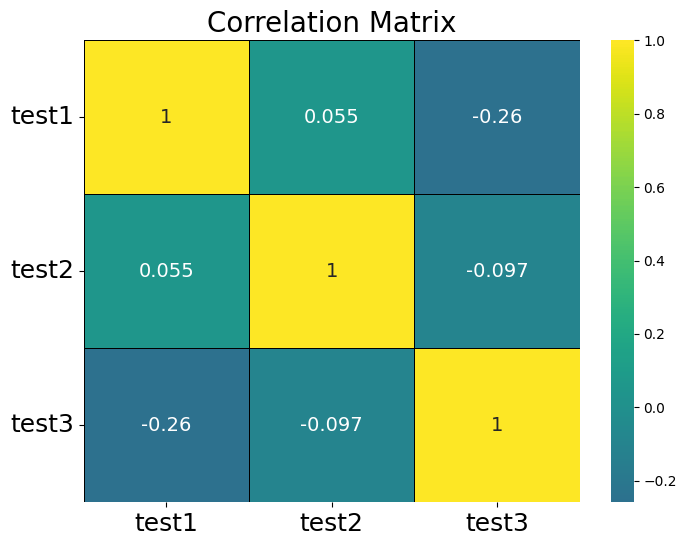

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

# Extract the relevant columns
relevant_data = data[['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']]

# Rename columns for better readability
relevant_data.columns = ['test1', 'test2', 'test3']

# Calculate the correlation matrix
correlation_matrix = relevant_data.corr()

# Plot the correlation matrix with colorblind-friendly color palette
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='viridis',   # Use 'cividis' for colorblind-friendly colors
            center=0,
            linewidths=0.5,
            linecolor='black',
            annot_kws={"size": 14})  # Increase annotation font size

# Set title and rotate labels for better readability
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=0, fontsize=18)  # Keep x-axis labels horizontal with larger font
plt.yticks(rotation=0, fontsize=18)  # Keep y-axis labels horizontal with larger font

plt.show()

## Training the random forest model

In [ ]:
# Instantiate random forest model with 100 decision trees
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
# Regenerate Features from balanced_Dat
#Load in functions to split data and train random forest regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
def train_test(dat):
        features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
        #features_columns = ['temperature_ambient_interp','rh_ambient_interp','BestEstimate_down_short_hemisp_interp']
        #features_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
        Dat=dat
        Features = Dat[features_columns]

        # Impute missing values with the mean for each column
        imputer = SimpleImputer(strategy='mean')
        Features = imputer.fit_transform(Features)

        # Define Independent variable
        Independent = Dat[['flag3']]

        # Check if the number of rows is now the same
        print(Features.shape[0])
        print(Independent.shape[0])
        test_df = Dat[Dat['date'] >= 20230101].copy()
        train_df=Dat[Dat['date'] < 20230101].copy()
        X_train=train_df[features_columns]
        y_train=train_df[['flag3']]
        X_test=test_df[features_columns]
        y_test=test_df[['flag3']]
        rf = RandomForestClassifier (n_estimators = 100,
                                n_jobs = -1,
                                oob_score = True,
                                bootstrap = True,
                                random_state = 42)
        # Train the model on training data
        rf.fit(X_train,np.array(y_train).flatten());

        # Use the forest's predict method on the test data
        predictions = rf.predict(X_test)
        pred_proba = rf.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, pred_proba)

        print('Training Score: {:.2f}\nOOB Score: {:.2f}\nValidation Score: {:.2f}'.format(
            rf.score(X_train, y_train),
            rf.oob_score_,
            rf.score(X_test, y_test)
        ))

        print("\nModel Performance Metrics:")
        print("ACCURACY:")
        print(f"  Mean: {accuracy:.4f}")
        print("PRECISION:")
        print(f"  Mean: {precision:.4f}")
        print("RECALL:")
        print(f"  Mean: {recall:.4f}")
        print("F1:")
        print(f"  Mean: {f1:.4f}")
        print("ROC_AUC:")
        print(f"  Mean: {roc_auc:.4f}")
        # Calculate confusion matrix
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, predictions)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Create custom annotations
        annotations = np.array([[f'{value}\n({percentage:.1f}%)'
                                for value, percentage in zip(row_values, row_percentages)]
                                for row_values, row_percentages in zip(cm, cm_percentage)])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage,
                    annot=annotations,
                    fmt='',
                    cmap='Blues',
                    cbar=True,
                    square=True)

        plt.title('Confusion Matrix', pad=20)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
        return cm_percentage, accuracy


In [ ]:
diff_2_4 = Dat_list[1].compare(Dat_list[2])
print("Differences between Dat_2 and Dat_4:")
print(diff_2_4)



Differences between Dat_2 and Dat_4:
      flag3      
       self other
131     0.0   1.0
132     0.0   1.0
133     0.0   1.0
134     0.0   1.0
135     0.0   1.0
...     ...   ...
81962   0.0   1.0
81963   0.0   1.0
81964   0.0   1.0
81965   0.0   1.0
81966   0.0   1.0

[7119 rows x 2 columns]


82068
82068
Training Score: 1.00
OOB Score: 0.98
Validation Score: 0.91

Model Performance Metrics:
ACCURACY:
  Mean: 0.9144
PRECISION:
  Mean: 0.5345
RECALL:
  Mean: 0.1468
F1:
  Mean: 0.2303
ROC_AUC:
  Mean: 0.7309


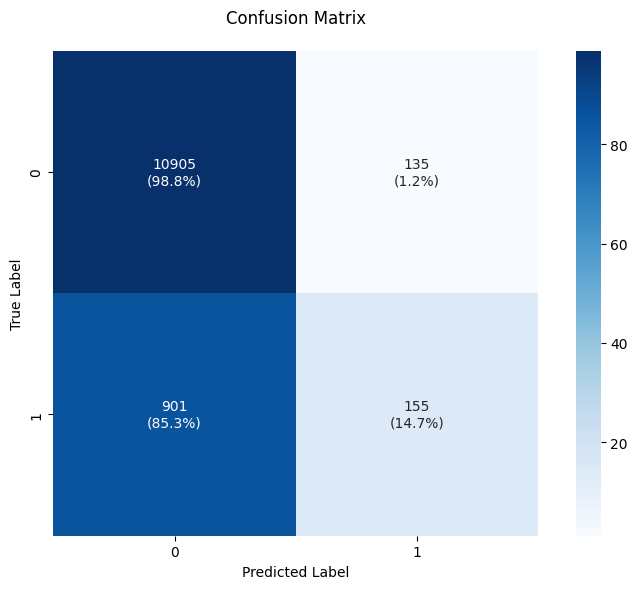

82068
82068
Training Score: 1.00
OOB Score: 0.97
Validation Score: 0.87

Model Performance Metrics:
ACCURACY:
  Mean: 0.8659
PRECISION:
  Mean: 0.7285
RECALL:
  Mean: 0.3698
F1:
  Mean: 0.4906
ROC_AUC:
  Mean: 0.7892


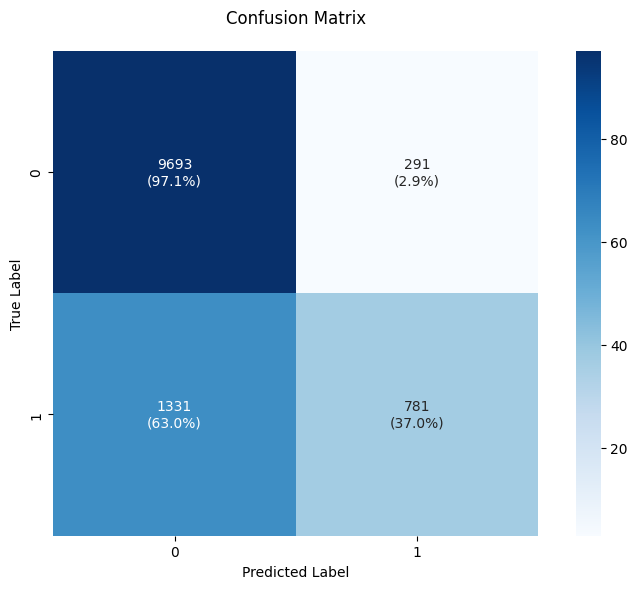

82068
82068
Training Score: 1.00
OOB Score: 0.97
Validation Score: 0.77

Model Performance Metrics:
ACCURACY:
  Mean: 0.7736
PRECISION:
  Mean: 0.6006
RECALL:
  Mean: 0.3978
F1:
  Mean: 0.4786
ROC_AUC:
  Mean: 0.7854


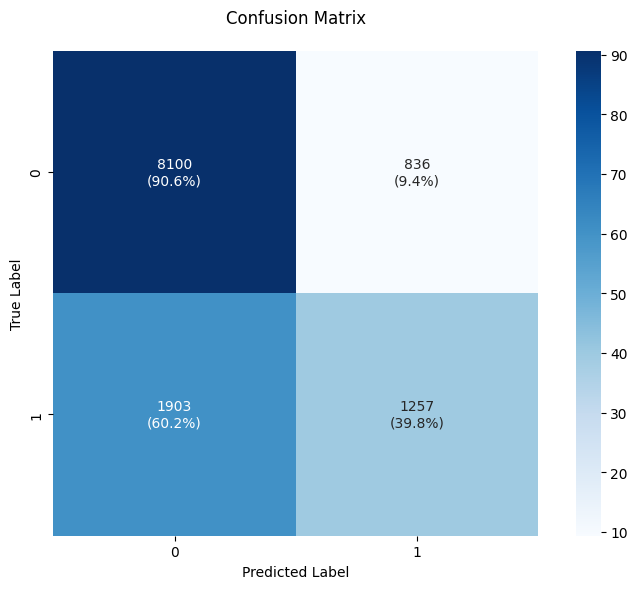

82068
82068


In [ ]:
cm_list=[]
accuracy_list=[]
for dat in Dat_list:
    CM_percentage, accuracy=train_test(dat)
    cm_list.append(CM_percentage)
    accuracy_list.append(accuracy*100)

In [ ]:
hours = [2, 4, 6, 8, 10]

# Extracting values for each metric
true_negatives = [cm[0][0] for cm in cm_list]
false_positives = [cm[0][1] for cm in cm_list]
false_negatives = [cm[1][0] for cm in cm_list]
true_positives = [cm[1][1] for cm in cm_list]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(hours, true_negatives, 'o-', label='True Negative (%)', color='blue')
plt.plot(hours, false_positives, 's-', label='False Positive (%)', color='green')
plt.plot(hours, false_negatives, '^-', label='False Negative (%)', color='orange')
plt.plot(hours, true_positives, 'D-', label='True Positive (%)', color='red')
plt.plot(hours, accuracy_list, 'D-', label='Accuracy Score(%)', color='black')
# Add labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Percentage (%)')
plt.title('Confusion Matrix Values Across Different Duration Label')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to match the hour values
plt.xticks(hours)

# Add legend
plt.legend(loc='best')

# Ensure y-axis starts at 0 for better comparison
plt.ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig('confusion_matrix_over_time.png', dpi=300, bbox_inches='tight')

In [ ]:
accuracy_list

[91.43518518518519,
 86.59060846560847,
 77.35615079365078,
 72.18088624338624,
 72.57771164021165]

In [ ]:
# Instantiate random forest model with 100 decision trees
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
# Regenerate Features from balanced_Dat
#Load in functions to split data and train random forest regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
def train_test_rf(dat):
        features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
        #features_columns = ['temperature_ambient_interp','rh_ambient_interp','BestEstimate_down_short_hemisp_interp']
        #features_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
        Dat=dat
        Features = Dat[features_columns]

        # Impute missing values with the mean for each column
        imputer = SimpleImputer(strategy='mean')
        Features = imputer.fit_transform(Features)

        # Define Independent variable
        Independent = Dat[['flag3']]

        # Check if the number of rows is now the same
        print(Features.shape[0])
        print(Independent.shape[0])
        test_df = Dat[Dat['date'] >= 20230101].copy()
        train_df=Dat[Dat['date'] < 20230101].copy()
        X_train=train_df[features_columns]
        y_train=train_df[['flag3']]
        X_test=test_df[features_columns]
        y_test=test_df[['flag3']]
        rf = RandomForestClassifier (n_estimators = 100,
                                n_jobs = -1,
                                oob_score = True,
                                bootstrap = True,
                                random_state = 42)
        # Train the model on training data
        rf.fit(X_train,np.array(y_train).flatten());

        # Use the forest's predict method on the test data
        predictions = rf.predict(X_test)
        pred_proba = rf.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, pred_proba)

        print('Training Score: {:.2f}\nOOB Score: {:.2f}\nValidation Score: {:.2f}'.format(
            rf.score(X_train, y_train),
            rf.oob_score_,
            rf.score(X_test, y_test)
        ))

        print("\nModel Performance Metrics:")
        print("ACCURACY:")
        print(f"  Mean: {accuracy:.4f}")
        print("PRECISION:")
        print(f"  Mean: {precision:.4f}")
        print("RECALL:")
        print(f"  Mean: {recall:.4f}")
        print("F1:")
        print(f"  Mean: {f1:.4f}")
        print("ROC_AUC:")
        print(f"  Mean: {roc_auc:.4f}")
        # Calculate confusion matrix
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, predictions)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Create custom annotations
        annotations = np.array([[f'{value}\n({percentage:.1f}%)'
                                for value, percentage in zip(row_values, row_percentages)]
                                for row_values, row_percentages in zip(cm, cm_percentage)])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage,
                    annot=annotations,
                    fmt='',
                    cmap='Blues',
                    cbar=True,
                    square=True)

        plt.title('Confusion Matrix', pad=20)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
        return rf, X_train, y_train


82068
82068
Training Score: 1.00
OOB Score: 0.98
Validation Score: 0.73

Model Performance Metrics:
ACCURACY:
  Mean: 0.7258
PRECISION:
  Mean: 0.6599
RECALL:
  Mean: 0.7483
F1:
  Mean: 0.7014
ROC_AUC:
  Mean: 0.8041


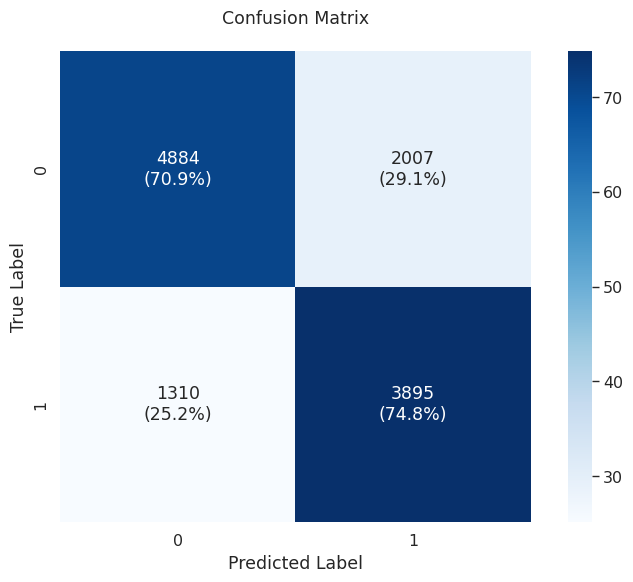

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


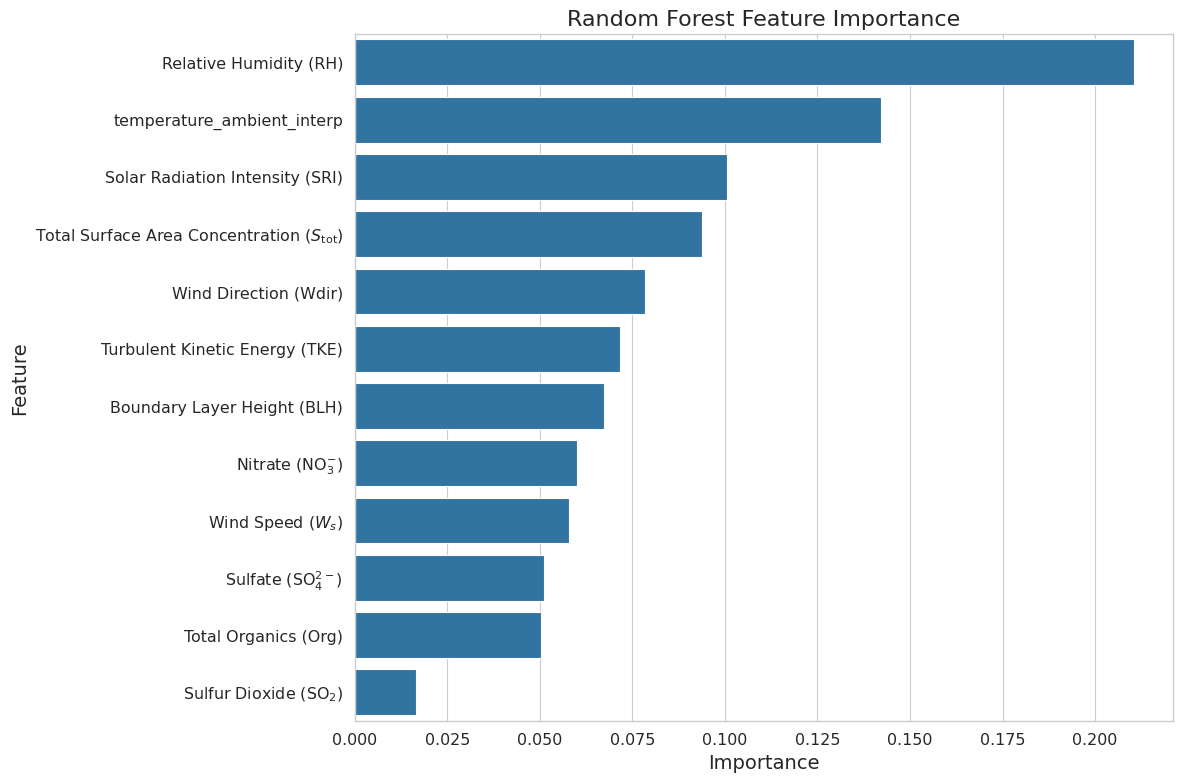

Top 10 Most Important Features:
                                              Feature  Importance
4                              Relative Humidity (RH)    0.210403
5                          temperature_ambient_interp    0.142093
11                    Solar Radiation Intensity (SRI)    0.100684
8   Total Surface Area Concentration ($S_{\mathrm{...    0.093752
6                               Wind Direction (Wdir)    0.078527
10                     Turbulent Kinetic Energy (TKE)    0.071573
0                         Boundary Layer Height (BLH)    0.067333
3                       Nitrate ($\mathrm{NO}_3^{-}$)    0.060033
7                                Wind Speed ($W_{s}$)    0.057752
2                      Sulfate ($\mathrm{SO}_4^{2-}$)    0.050979

Number of features needed for 90% of importance: 10


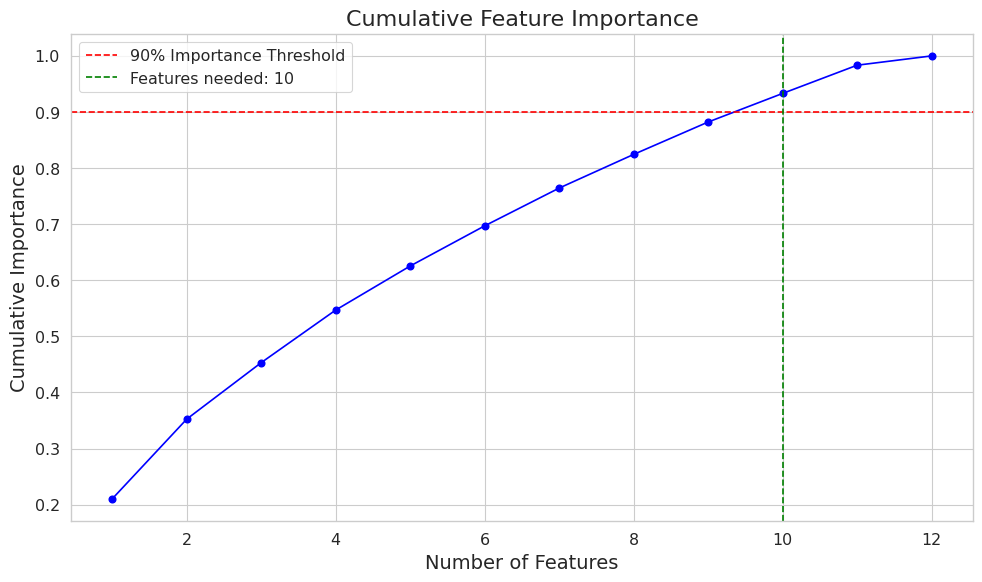

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Get feature importances
rf, X_train, y_train= train_test_rf(dat)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
feature_to_friendly_name = {
    'BestEstimate_down_short_hemisp_interp': 'Solar Radiation Intensity (SRI)',
    'rh_ambient_interp': 'Relative Humidity (RH)',
  'turbulent_kinetic_energy_interp': 'Turbulent Kinetic Energy (TKE)',
    'total_SA_conc_smps_interp': 'Total Surface Area Concentration ($S_{\\mathrm{tot}}$)',
    'wind_direction_interp': 'Wind Direction (Wdir)',
    'wind_speed_interp': 'Wind Speed ($W_{s}$)',
    'bl_height_1_interp': 'Boundary Layer Height (BLH)',
    'total_organics_interp': 'Total Organics (Org)',
    'sulfate_interp': 'Sulfate ($\\mathrm{SO}_4^{2-}$)',
    'nitrate_interp': 'Nitrate ($\\mathrm{NO}_3^{-}$)',
    'so2_interp': 'Sulfur Dioxide ($\\mathrm{SO}_2$)'
}
# Assuming you have feature names stored in a variable called 'feature_names'
# If not, you can create a placeholder
try:
    feature_names = X_train.columns
except:
    feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df['Feature']=importance_df['Feature'].replace(feature_to_friendly_name)
# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# Print top 10 features with their importance values
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Calculate cumulative importance
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()

# Find how many features are needed to reach 90% importance
features_for_90pct = len(importance_df[importance_df['Cumulative_Importance'] <= 0.90]) + 1
print(f"\nNumber of features needed for 90% of importance: {features_for_90pct}")

# Create cumulative importance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1), importance_df['Cumulative_Importance'], 'b-', marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Importance Threshold')
plt.axvline(x=features_for_90pct, color='g', linestyle='--',
            label=f'Features needed: {features_for_90pct}')
plt.title('Cumulative Feature Importance', fontsize=16)
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


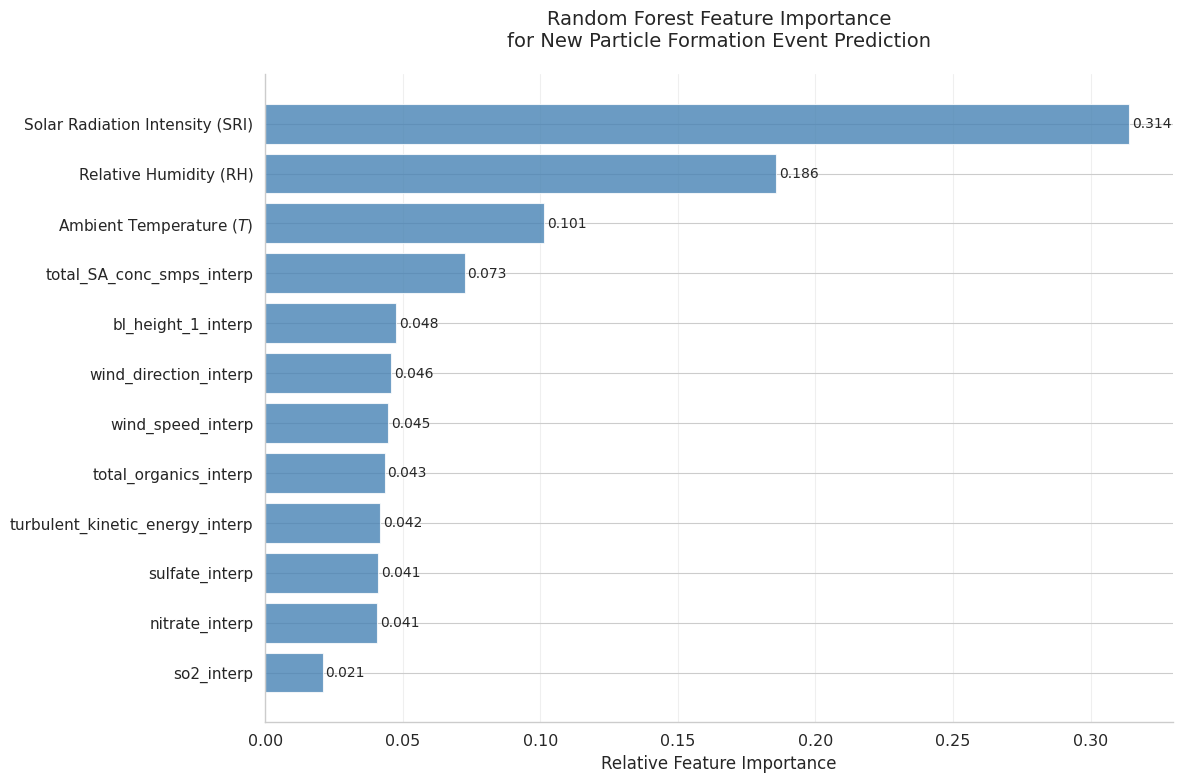


Model Performance Metrics (averaged across folds):
ACCURACY:
  Mean: 0.8601 ± 0.0107
PRECISION:
  Mean: 0.6765 ± 0.0275
RECALL:
  Mean: 0.6687 ± 0.0700
F1:
  Mean: 0.6704 ± 0.0357
ROC_AUC:
  Mean: 0.9013 ± 0.0226


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
#features_columns = ['temperature_ambient_interp','rh_ambient_interp','BestEstimate_down_short_hemisp_interp']
feature_to_friendly_name = {
    'BestEstimate_down_short_hemisp_interp': 'Solar Radiation Intensity (SRI)',
    'rh_ambient_interp': 'Relative Humidity (RH)',
  'turbulent_kinetic_energy_interp': 'Turbulent Kinetic Energy (TKE)',
    'total_SA_conc_smps_interp': 'Total Surface Area Concentration ($S_{\\mathrm{tot}}$)',
    'wind_direction_interp': 'Wind Direction (Wdir)',
    'wind_speed_interp': 'Wind Speed ($W_{s}$)',
    'bl_height_1_interp': 'Boundary Layer Height (BLH)',
    'total_organics_interp': 'Total Organics (Org)',
    'sulfate_interp': 'Sulfate ($\\mathrm{SO}_4^{2-}$)',
    'nitrate_interp': 'Nitrate ($\\mathrm{NO}_3^{-}$)',
    'so2_interp': 'Sulfur Dioxide ($\\mathrm{SO}_2$)'
}
feature_to_friendly_name = {
    'BestEstimate_down_short_hemisp_interp': 'Solar Radiation Intensity (SRI)',
    'rh_ambient_interp': 'Relative Humidity (RH)',
    'temperature_ambient_interp': 'Ambient Temperature ($T$)'
}

# Set up cross-validation and metrics storage
tscv = TimeSeriesSplit(n_splits=4)
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
all_feature_importances = []

# Prepare features and target
X = Dat[features_columns]
y = Dat['flag3']

# Perform time series cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    try:
        # Split data maintaining temporal order
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train Random Forest
        rf_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42
        )
        rf_model.fit(X_train, y_train)

        # Store feature importances and calculate predictions
        all_feature_importances.append(rf_model.feature_importances_)
        predictions = rf_model.predict(X_test)
        pred_proba = rf_model.predict_proba(X_test)[:, 1]

        # Calculate and store metrics
        metrics['accuracy'].append(accuracy_score(y_test, predictions))
        metrics['precision'].append(precision_score(y_test, predictions))
        metrics['recall'].append(recall_score(y_test, predictions))
        metrics['f1'].append(f1_score(y_test, predictions))
        metrics['roc_auc'].append(roc_auc_score(y_test, pred_proba))

        print(f"Completed fold {fold}")

    except Exception as e:
        print(f"Error in fold {fold}: {str(e)}")
        continue

# Calculate and prepare importance data
mean_importances = np.mean(all_feature_importances, axis=0)
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': mean_importances
})
importance_df['Feature'] = importance_df['Feature'].map(
    lambda x: feature_to_friendly_name.get(x, x)
)
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create horizontal bar plot
bars = plt.barh(range(len(importance_df)), importance_df['Importance'],
                color='steelblue', alpha=0.8)

# Customize the plot
plt.yticks(range(len(importance_df)), importance_df['Feature'], fontsize=11)
plt.xlabel('Relative Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance\nfor New Particle Formation Event Prediction',
          fontsize=14, pad=20)

# Add value labels and customize appearance
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             ha='left', va='center', fontsize=10)

plt.grid(True, axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance metrics
print("\nModel Performance Metrics (averaged across folds):")
for metric_name, values in metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper()}:")
    print(f"  Mean: {mean_val:.4f} ± {std_val:.4f}")

Completed fold 1
Completed fold 2
Completed fold 3
Error in fold 4: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by RandomForestClassifier.


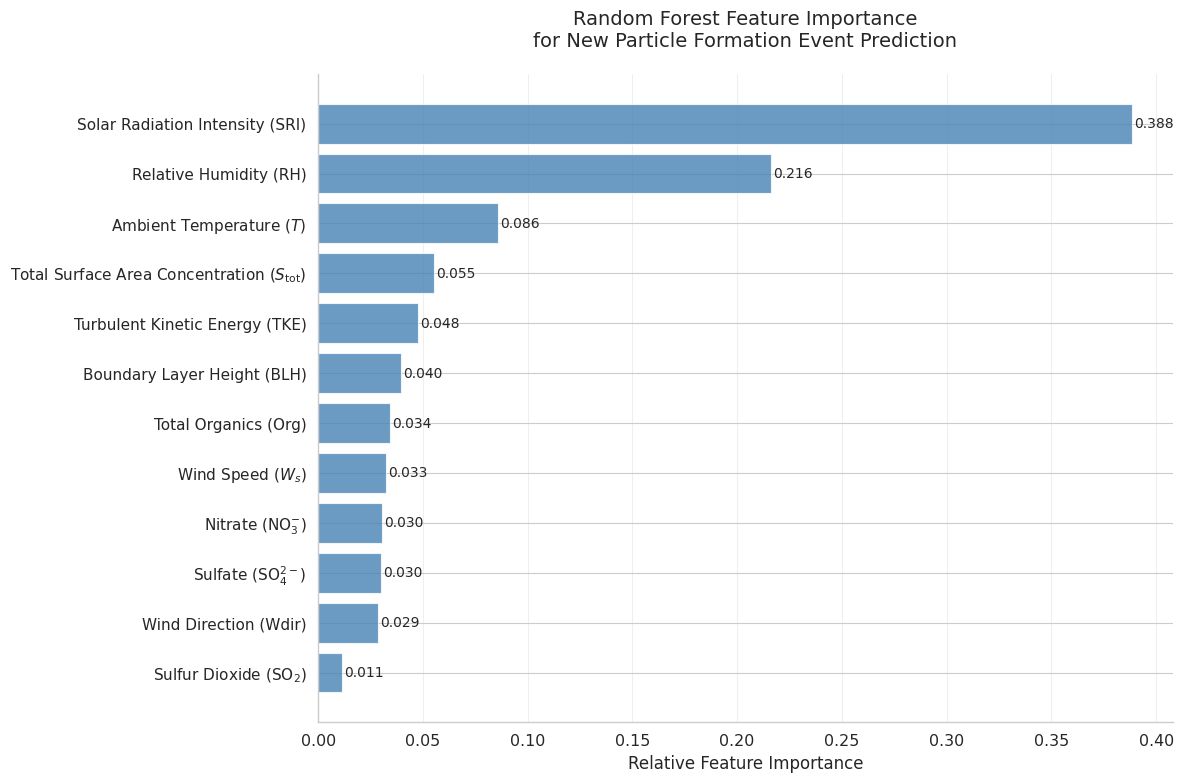


Model Performance Metrics (averaged across folds):
ACCURACY:
  Mean: 0.8580 ± 0.0075
PRECISION:
  Mean: 0.6653 ± 0.0154
RECALL:
  Mean: 0.6842 ± 0.0207
F1:
  Mean: 0.6746 ± 0.0171
ROC_AUC:
  Mean: 0.9020 ± 0.0122


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class BlockedTimeSeriesSplit:
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def split(self, X):
        n_samples = len(X)
        block_size = n_samples // self.n_splits
        for i in range(self.n_splits):
            train_end = (i + 1) * block_size
            test_end = train_end + block_size if i < self.n_splits - 1 else n_samples
            yield (np.arange(0, train_end), np.arange(train_end, test_end))

# Rest of feature definitions remain the same
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

feature_to_friendly_name = {
    'BestEstimate_down_short_hemisp_interp': 'Solar Radiation Intensity (SRI)',
    'rh_ambient_interp': 'Relative Humidity (RH)',
    'temperature_ambient_interp': 'Ambient Temperature ($T$)',
    'turbulent_kinetic_energy_interp': 'Turbulent Kinetic Energy (TKE)',
    'total_SA_conc_smps_interp': 'Total Surface Area Concentration ($S_{\\mathrm{tot}}$)',
    'wind_direction_interp': 'Wind Direction (Wdir)',
    'wind_speed_interp': 'Wind Speed ($W_{s}$)',
    'bl_height_1_interp': 'Boundary Layer Height (BLH)',
    'total_organics_interp': 'Total Organics (Org)',
    'sulfate_interp': 'Sulfate ($\\mathrm{SO}_4^{2-}$)',
    'nitrate_interp': 'Nitrate ($\\mathrm{NO}_3^{-}$)',
    'so2_interp': 'Sulfur Dioxide ($\\mathrm{SO}_2$)'
}


blocked_cv = BlockedTimeSeriesSplit(n_splits=4)
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
all_feature_importances = []

X = Dat[features_columns]
y = Dat['flag3']

for fold, (train_index, test_index) in enumerate(blocked_cv.split(X), 1):
    try:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        rf_model.fit(X_train, y_train)

        all_feature_importances.append(rf_model.feature_importances_)
        predictions = rf_model.predict(X_test)
        pred_proba = rf_model.predict_proba(X_test)[:, 1]

        for metric_name, metric_func in [
            ('accuracy', accuracy_score),
            ('precision', precision_score),
            ('recall', recall_score),
            ('f1', f1_score),
            ('roc_auc', roc_auc_score)
        ]:
            metrics[metric_name].append(metric_func(y_test, predictions if metric_name != 'roc_auc' else pred_proba))

        print(f"Completed fold {fold}")

    except Exception as e:
        print(f"Error in fold {fold}: {str(e)}")
        continue

# Calculate and prepare importance data
mean_importances = np.mean(all_feature_importances, axis=0)
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': mean_importances
})
importance_df['Feature'] = importance_df['Feature'].map(
    lambda x: feature_to_friendly_name.get(x, x)
)
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create horizontal bar plot
bars = plt.barh(range(len(importance_df)), importance_df['Importance'],
                color='steelblue', alpha=0.8)

# Customize the plot
plt.yticks(range(len(importance_df)), importance_df['Feature'], fontsize=11)
plt.xlabel('Relative Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance\nfor New Particle Formation Event Prediction',
          fontsize=14, pad=20)

# Add value labels and customize appearance
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             ha='left', va='center', fontsize=10)

plt.grid(True, axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance metrics
print("\nModel Performance Metrics (averaged across folds):")
for metric_name, values in metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper()}:")
    print(f"  Mean: {mean_val:.4f} ± {std_val:.4f}")

10-fold

Model Performance Metrics (averaged across folds):
ACCURACY:
  Mean: 0.9788 ± 0.0012
PRECISION:
  Mean: 0.9605 ± 0.0050
RECALL:
  Mean: 0.9413 ± 0.0028
F1:
  Mean: 0.9508 ± 0.0026
ROC_AUC:
  Mean: 0.9971 ± 0.0003


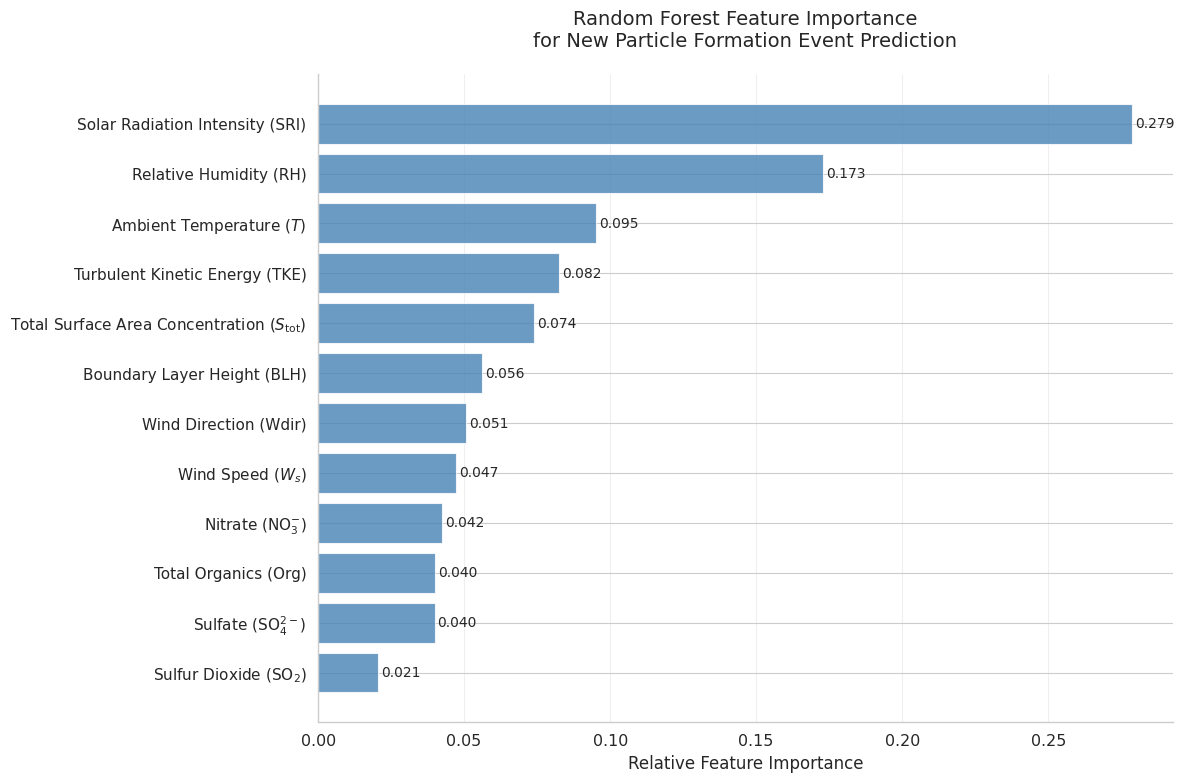


Model Performance Metrics (averaged across folds):
ACCURACY:
  Mean: 0.9788 ± 0.0012
PRECISION:
  Mean: 0.9605 ± 0.0050
RECALL:
  Mean: 0.9413 ± 0.0028
F1:
  Mean: 0.9508 ± 0.0026
ROC_AUC:
  Mean: 0.9971 ± 0.0003


In [ ]:
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp',
                    'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

model = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

Features = Dat[features_columns]
Independent = Dat[['flag3']]

feature_importances_per_fold = []
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
for train_index, test_index in kf.split(Features):
    X_train_fold, X_test_fold = Features.iloc[train_index], Features.iloc[test_index]
    y_train_fold, y_test_fold = Independent.iloc[train_index].values.ravel(), Independent.iloc[test_index].values.ravel()

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    y_pred_proba = model.predict_proba(X_test_fold)[:, 1]
    # Calculate and store precision score
    precision = precision_score(y_test_fold, y_pred)
    metrics['precision'].append(precision)

    feature_importances_per_fold.append(model.feature_importances_)

    metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics['precision'].append(precision_score(y_test_fold, y_pred))
    metrics['recall'].append(recall_score(y_test_fold, y_pred))
    metrics['f1'].append(f1_score(y_test_fold, y_pred))
    metrics['roc_auc'].append(roc_auc_score(y_test_fold, y_pred_proba))

print("Model Performance Metrics (averaged across folds):")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.upper()}:")
    print(f"  Mean: {mean:.4f} ± {std:.4f}")
mean_importances = np.mean(feature_importances_per_fold, axis=0)
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': mean_importances
})
importance_df['Feature'] = importance_df['Feature'].map(
    lambda x: feature_to_friendly_name.get(x, x)
)
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create horizontal bar plot
bars = plt.barh(range(len(importance_df)), importance_df['Importance'],
                color='steelblue', alpha=0.8)

# Customize the plot
plt.yticks(range(len(importance_df)), importance_df['Feature'], fontsize=11)
plt.xlabel('Relative Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance\nfor New Particle Formation Event Prediction',
          fontsize=14, pad=20)

# Add value labels and customize appearance
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             ha='left', va='center', fontsize=10)

plt.grid(True, axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance metrics
print("\nModel Performance Metrics (averaged across folds):")
for metric_name, values in metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper()}:")
    print(f"  Mean: {mean_val:.4f} ± {std_val:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

top_features_df = importance_df
# Generate colors using the 'viridis' colormap, evenly spaced for each feature
colors = plt.cm.viridis(np.linspace(0, 1, num=len(top_features_df)))

# Plot using Matplotlib
plt.figure(figsize=(10, 4))

# Plot the bars with the specified colors
bars = plt.barh(top_features_df['Feature'], top_features_df['Mean Importance'],
                xerr=top_features_df['Importance Std'].values, capsize=5, color=colors)

# Customize the plot
plt.title('Top three Feature Importance Ranking', fontsize=18)
plt.xlabel('Feature Importance', fontsize=18)

# Set the font size for the x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.tight_layout()
plt.show()



KeyError: 'Mean Importance'

<Figure size 1000x400 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(Features, Independent, test_size=0.3, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train.values.ravel())

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate precision, recall, and F1-score for each class (0 and 1)
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix to derive class-specific accuracy
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate class-specific accuracy for class 0 and class 1 using the overall accuracy formula
# Accuracy for class 0: TP and TN are considered for class 0 as the positive class
accuracy_class_0 = (tn + tp) / (tp + fn + fp + tn)

# Accuracy for class 1: TP and TN are considered for class 1 as the positive class
accuracy_class_1 = (tp + tn) / (tp + fn + fp + tn)

# Print the results
print(f'Class 0 - Precision: {precision_class_0:.4f}, Recall: {recall_class_0:.4f}, F1-score: {f1_class_0:.4f}, Accuracy: {accuracy_class_0:.4f}')
print(f'Class 1 - Precision: {precision_class_1:.4f}, Recall: {recall_class_1:.4f}, F1-score: {f1_class_1:.4f}, Accuracy: {accuracy_class_1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')


Class 0 - Precision: 0.9795, Recall: 0.9883, F1-score: 0.9838, Accuracy: 0.9746
Class 1 - Precision: 0.9564, Recall: 0.9256, F1-score: 0.9408, Accuracy: 0.9746
Overall Accuracy: 0.9746


In [ ]:
y_test

,flag3
33408,0
60875,0
61101,0
24147,1
9254,0
...,...
18188,0
18373,1
6133,0
75949,1


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp', 'wind_speed_interp',
                    'total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
#features_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
# Split the data into features and target variable
Features = Dat[features_columns]
Independent = Dat['flag3']

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up KFold cross-validation with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# To store accuracy for each fold
accuracy_per_fold = []

# Perform manual 10-fold cross-validation
for train_index, test_index in kf.split(Features):
    # Split the data into training and test sets for the current fold
    X_train_fold, X_test_fold = Features.iloc[train_index], Features.iloc[test_index]
    y_train_fold, y_test_fold = Independent.iloc[train_index], Independent.iloc[test_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = model.predict(X_test_fold)

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_per_fold.append(accuracy)

# Convert accuracy list to a NumPy array for easier calculations
accuracy_per_fold = np.array(accuracy_per_fold)

# Calculate mean and standard deviation of accuracy across all folds
mean_accuracy = np.mean(accuracy_per_fold)
std_accuracy = np.std(accuracy_per_fold)

# Print the results
print(f'Overall 10-Fold Cross-Validation Accuracy: Mean = {mean_accuracy:.4f}, Std = {std_accuracy:.4f}')


Overall 10-Fold Cross-Validation Accuracy: Mean = 0.9788, Std = 0.0012


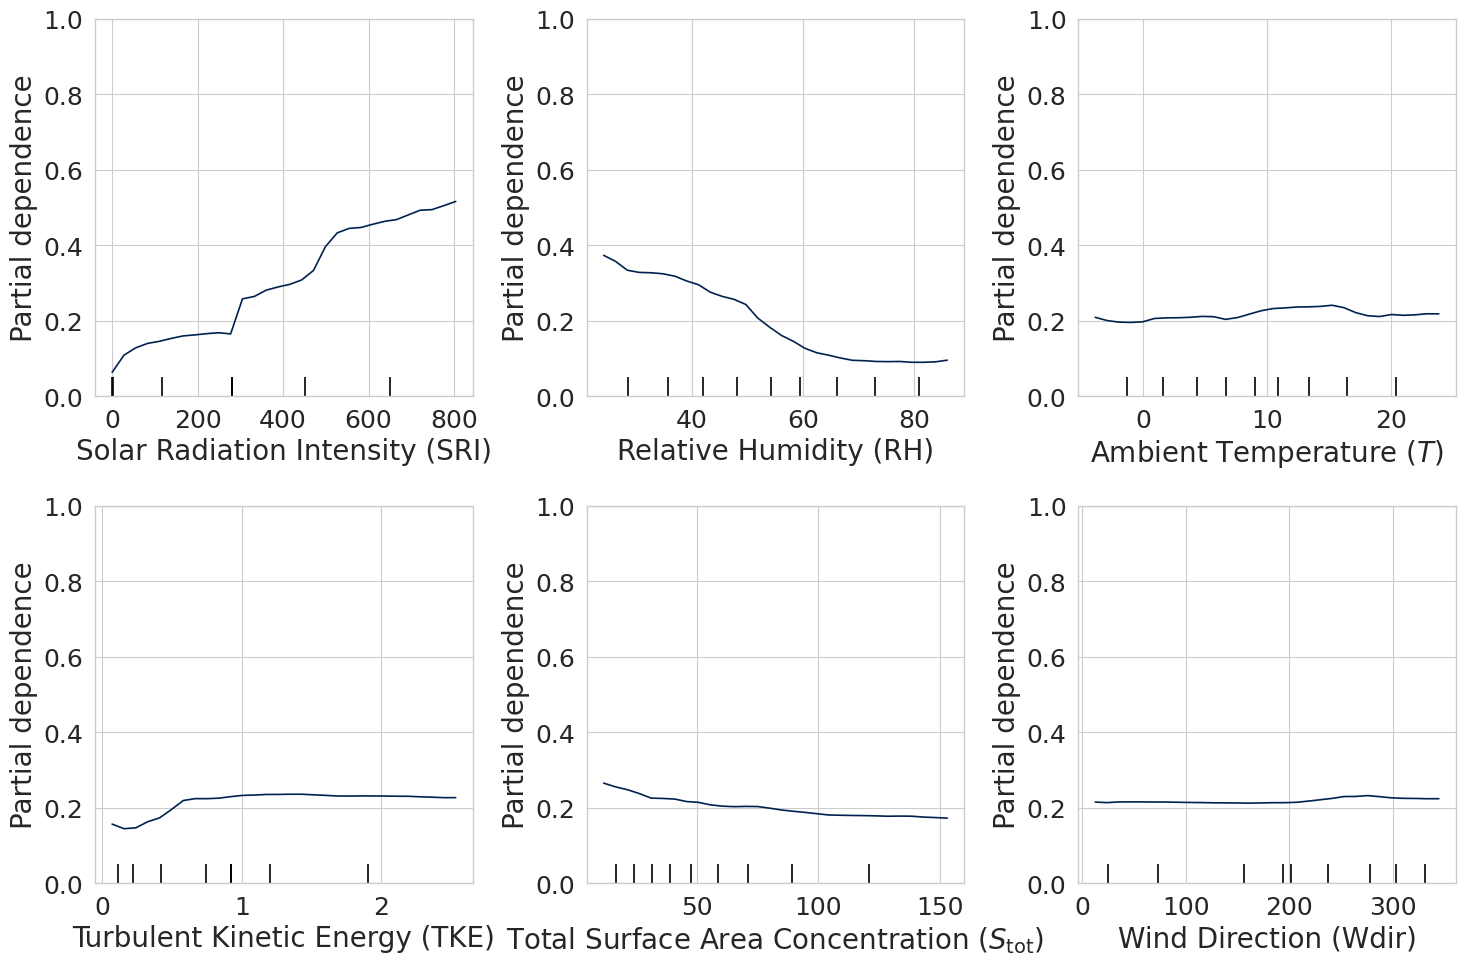

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
# Set global parameters for consistent font sizes
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.prop_cycle': plt.cycler('color', plt.cm.cividis(np.linspace(0, 1, 10)))
})

#Dat = pd.read_csv(r'F:\NPF_ML\sirs20s\aligned_data_sirs20s.csv')
Dat = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
#features_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]
#friendly_names = [
#    'test1',
#    'test2',
#    'test3',
#]

X = Dat[features_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=features_columns)

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Select the features for which PDPs will be generated
sorted_features = ['Solar Radiation Intensity (SRI)', 'Relative Humidity (RH)', 'Ambient Temperature ($T$)',
                   'Turbulent Kinetic Energy (TKE)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)',
                   'Wind Direction (Wdir)']
#sorted_features=[   'test1',
#     'test2',
#    'test3']
# Dictionary to store partial dependence results
pdp_results = {feature: [] for feature in sorted_features}

# Perform K-Fold cross-validation
for train_index, _ in kf.split(X_imputed_df):
    X_train_fold = X_imputed_df.iloc[train_index]
    y_train_fold = y.iloc[train_index]

    # Train RandomForest model on the current fold
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
    rf.fit(X_train_fold, y_train_fold)

    # Calculate partial dependence for each feature
    for feature in sorted_features:
        feature_index = friendly_names.index(feature)
        pdp_result = partial_dependence(rf, X_train_fold, [feature_index], grid_resolution=30)

        # Extract the partial dependence values for the current feature
        pdp_values = pdp_result.average[0]  # Extract the PDP values correctly
        pdp_results[feature].append(pdp_values)

# Calculate mean and standard deviation for each feature's partial dependence
mean_pdp = {}
std_pdp = {}
for feature, pdp_values in pdp_results.items():
    pdp_values = np.array(pdp_values, dtype=float)  # Ensure correct data type
    mean_pdp[feature] = np.mean(pdp_values, axis=0)
    std_pdp[feature] = np.std(pdp_values, axis=0)

# Generate PDP plots with error bars
n_cols = 3  # Number of columns
n_rows = 2  # Number of rows to fit all top six features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed

for i, feature in enumerate(sorted_features):
    ax = axs.flat[i]
    feature_index = friendly_names.index(feature)

    # Generate Partial Dependence Plot using PartialDependenceDisplay
    PartialDependenceDisplay.from_estimator(
        rf, X_train_fold, features=[feature_index], feature_names=friendly_names, ax=ax, grid_resolution=30
    )
    ax.set_xlabel(feature)
    ax.set_ylabel('Partial Dependence')
    ax.tick_params(axis='both', top=False)  # Disable top ticks

for ax in fig.axes:
    ax.set_ylim(0, 1)  # Adjust y-axis limits as needed

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Examining variable importance

Models can be interpreted in several ways. One way is to examine variable importance.

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled

Similar importance scores can also be used for exploratory analysis and for understanding relative importance of different factors for describing a phenomenon, particularly relevant when the features are more or less independent.

### References

Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.

Venter, Z. S., Chakraborty, T., & Lee, X. (2021). Crowdsourced air temperatures contrast satellite measures of the urban heat island and its mechanisms. Science Advances, 7(22), eabb9569.

In [ ]:
#For computing permutation scores
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
def r2(model, X_train, y_train):
    return r2_score(y_train, model.predict(X_train))

In [ ]:
r2

<function __main__.r2(model, X_train, y_train)>

In [ ]:
rf

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
#Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp

# Normalizing the permutation importances
perm_imp_rfpimp['Importance'] = perm_imp_rfpimp['Importance'] / perm_imp_rfpimp['Importance'].sum()

# Print normalized permutation importances
print(perm_imp_rfpimp)


                                       Importance
Feature                                          
BestEstimate_down_short_hemisp_interp    0.308876
rh_ambient_interp                        0.226430
turbulent_kinetic_energy_interp          0.110059
temperature_ambient_interp               0.104536
total_SA_conc_smps_interp                0.085996
wind_speed_interp                        0.039053
nitrate_interp                           0.033925
wind_direction_interp                    0.031953
bl_height_1_interp                       0.028008
total_organics_interp                    0.014990
sulfate_interp                           0.011440
so2_interp                               0.004734


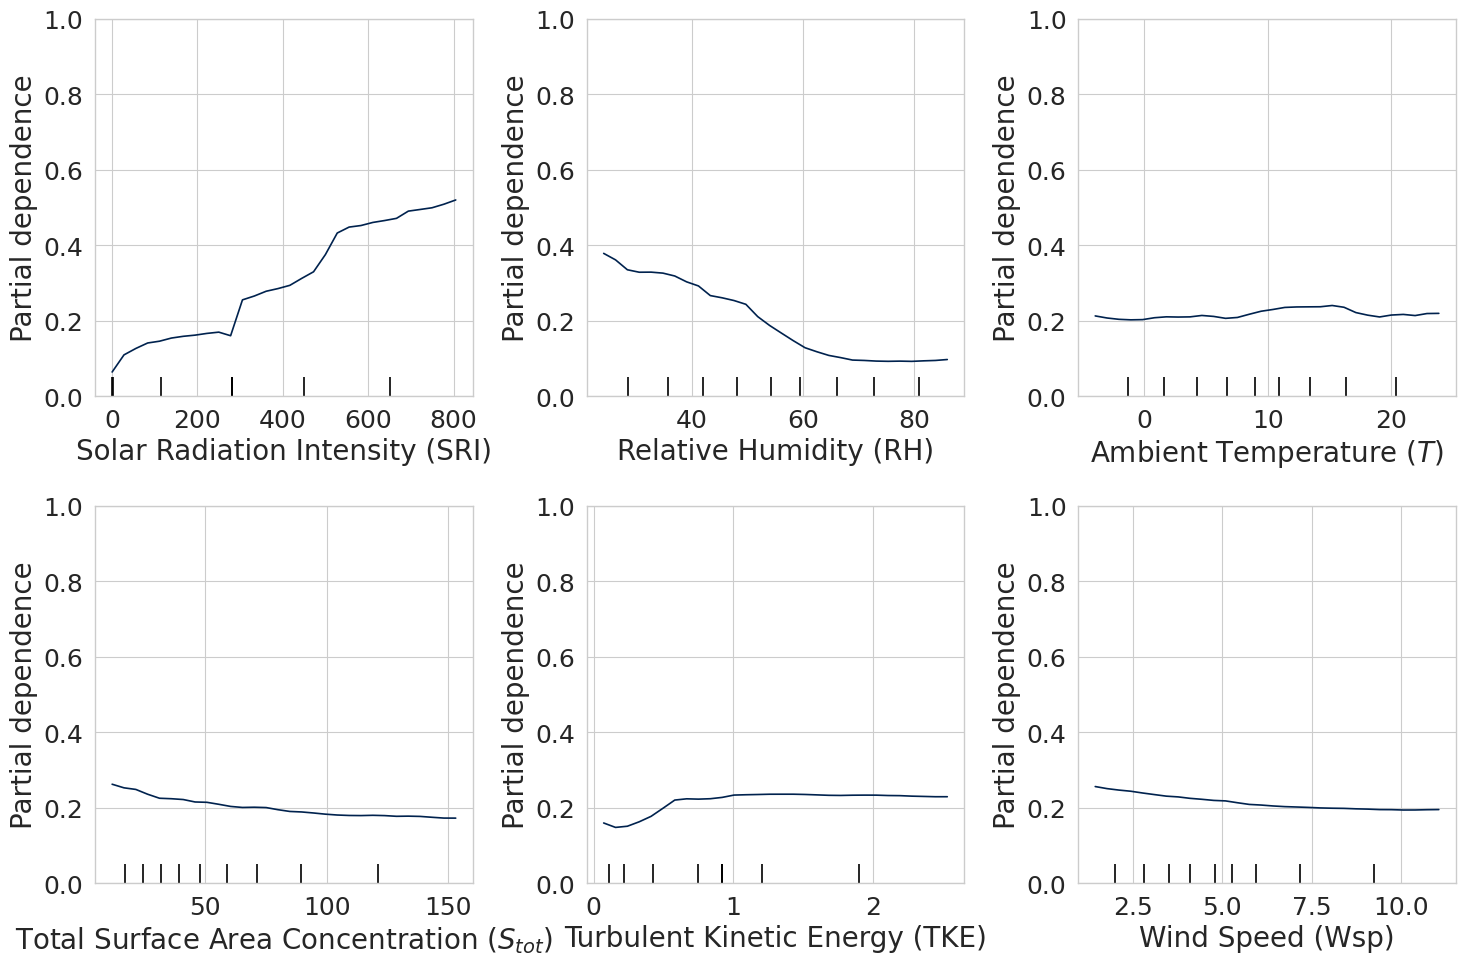

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                   'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                   'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
#features_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{tot}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]
#friendly_names = [
#    'test1',
#    'test2',
#    'test3',
#]
X = Dat[features_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
sorted_features = perm_imp_rfpimp.index.tolist()[:6]  # Focus on the top six features

# Generate Partial Dependence Plots for the top six features
n_cols = 3  # Adjust the number of columns as needed
n_rows = 2  # Number of rows to fit all top six features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed

for i, feature in enumerate(sorted_features):
    ax = axs.flat[i]
    feature_index = friendly_names.index(feature)
    PartialDependenceDisplay.from_estimator(rf, X_train, features=[feature_index], feature_names=friendly_names, ax=ax, grid_resolution=30)
    ax.set_xlabel(ax.get_xlabel(), fontsize=25)  # Set x-axis label size
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)  # Set y-axis label size
    ax.tick_params(axis='both', labelsize=20)  # Set tick label size
    ax.tick_params(top=False)  # Disable top ticks

# Set consistent y-axis limits after all plots have been generated
for ax in fig.axes:
    ax.set_ylim(0, 1)  # Adjust y-axis limits as needed

plt.tight_layout()
plt.show()


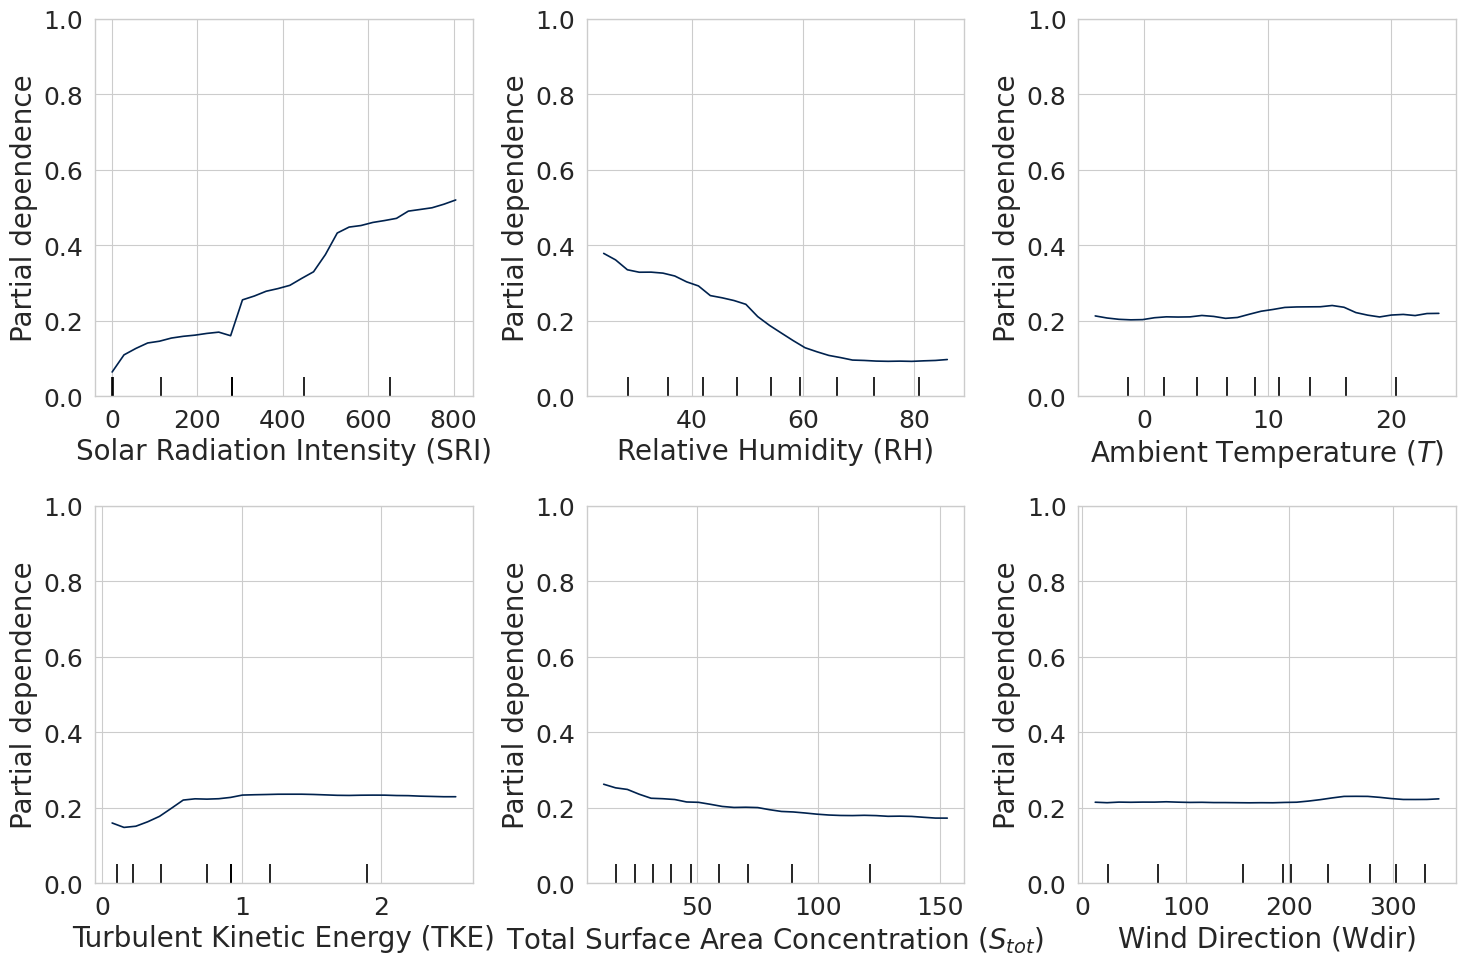

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

# Set global parameters to ensure font sizes are consistent
plt.rcParams.update({
    'font.size': 18,  # Sets the default font size
    'axes.labelsize': 20,  # Sets the fontsize for x and y labels
    'axes.titlesize': 20,  # Sets the fontsize for subplot titles if any
    'xtick.labelsize': 18,  # Sets the fontsize for the xticks
    'ytick.labelsize': 18,  # Sets the fontsize for the yticks
    'axes.prop_cycle': plt.cycler('color', plt.cm.cividis(np.linspace(0, 1, 10)))  # Uses the 'cividis' colormap
})

def r2(model, X, y):
    return r2_score(y, model.predict(X))

features_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                   'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                   'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
#features_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{tot}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]
#friendly_names = [
#    'test1',
#    'test2',
#    'test3',
#]

X = Dat[features_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
sorted_features = ['Solar Radiation Intensity (SRI)', 'Relative Humidity (RH)', 'Ambient Temperature ($T$)',
                  'Turbulent Kinetic Energy (TKE)', 'Total Surface Area Concentration ($S_{tot}$)',
                'Wind Direction (Wdir)']
#sorted_features=[   'test1',
#     'test2',
#    'test3']
# Generate Partial Dependence Plots for the top six features
n_cols = 3  # Adjust the number of columns as needed
n_rows = 2  # Number of rows to fit all top six features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed

for i, feature in enumerate(sorted_features):
    ax = axs.flat[i]
    feature_index = friendly_names.index(feature)
    PartialDependenceDisplay.from_estimator(rf, X_train, features=[feature_index], feature_names=friendly_names, ax=ax, grid_resolution=30)
    ax.set_xlabel(ax.get_xlabel())  # Now font sizes are globally set
    ax.set_ylabel(ax.get_ylabel())  # Now font sizes are globally set
    ax.tick_params(axis='both', top=False)  # Disable top ticks and keep other params

    # Set consistent y-axis limits after all plots have been generated
for ax in fig.axes:
    ax.set_ylim(0, 1)  # Adjust y-axis limits as needed

plt.tight_layout()
plt.show()



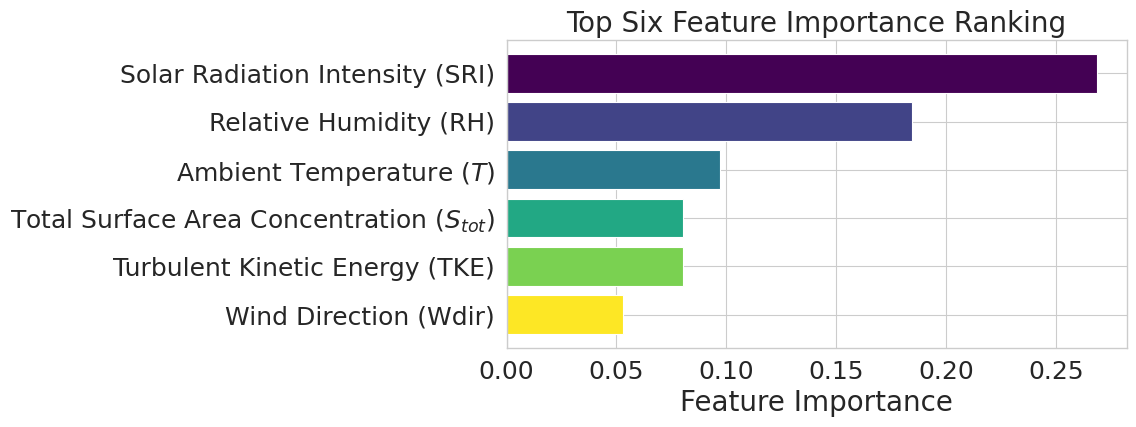

                                        Features  Importance
11               Solar Radiation Intensity (SRI)    0.268619
4                         Relative Humidity (RH)    0.184583
5                      Ambient Temperature ($T$)    0.097312
8   Total Surface Area Concentration ($S_{tot}$)    0.080212
10                Turbulent Kinetic Energy (TKE)    0.080133
6                          Wind Direction (Wdir)    0.052854


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Calculate feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for easier plotting
importances_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and select the top six
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(6)

# Plotting the Top 6 Feature Importances
plt.figure(figsize=(8, 4))  # Adjust size as needed
colors = plt.cm.viridis(np.linspace(0, 1, num=len(importances_df)))
plt.barh(importances_df['Features'], importances_df['Importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Top Six Feature Importance Ranking')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()

print(importances_df)

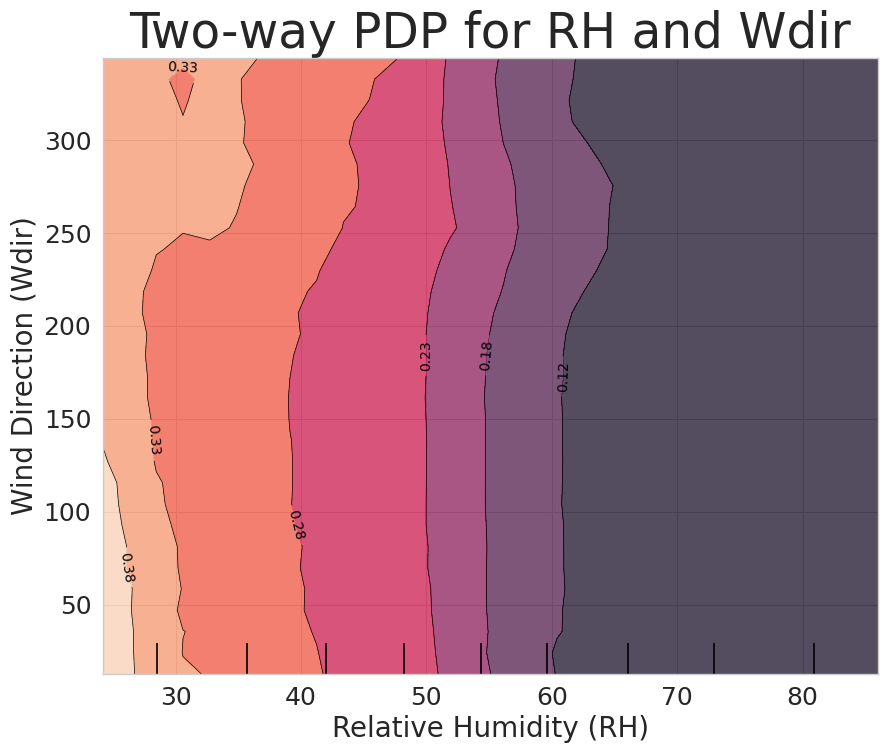

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

#feature_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                   'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                   'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{tot}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]
#friendly_names = [
#    'test1',
#    'test2',
#    'test3',
#]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Generate a two-way Partial Dependence Plot for the top two features
fig, ax = plt.subplots(figsize=(10, 8))
features_to_plot = (friendly_names.index('Relative Humidity (RH)'), friendly_names.index('Wind Direction (Wdir)'))
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)
ax.tick_params(axis='both', labelsize=27)  # Ensure tick label size
#ax.set_xlabel('SRI (W m$^{-2}$)', fontsize=32)  # Increase font size of the x-axis label
#ax.set_ylabel('RH (%)', fontsize=32)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for RH and Wdir', fontsize=35)
plt.show()


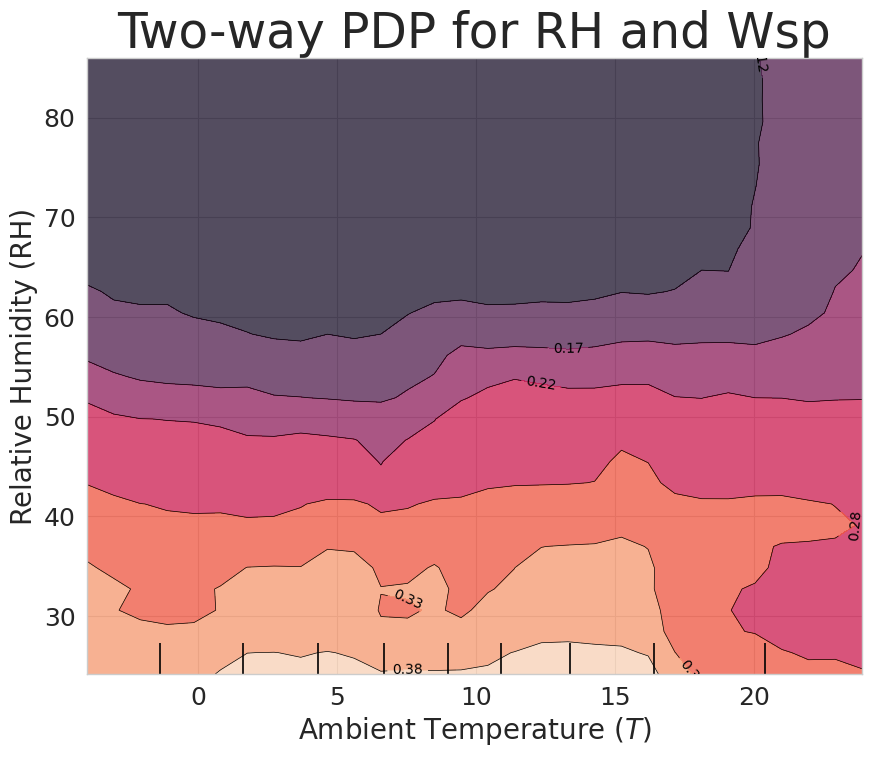

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))
#feature_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']

feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                   'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                   'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{tot}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]
#friendly_names = [
#    'test1',
#    'test2',
#    'test3',
#]


X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Generate a two-way Partial Dependence Plot for Ambient Temperature and Relative Humidity
fig, ax = plt.subplots(figsize=(10, 8))
features_to_plot = [friendly_names.index('Ambient Temperature ($T$)'), friendly_names.index('Relative Humidity (RH)')]
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)
ax.tick_params(axis='both', labelsize=27)  # Ensure tick label size
#ax.set_xlabel('$T$ (°C)', fontsize=32)  # Increase font size of the x-axis label
#ax.set_ylabel('RH (%)', fontsize=32)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for RH and Wsp', fontsize=35)
plt.show()


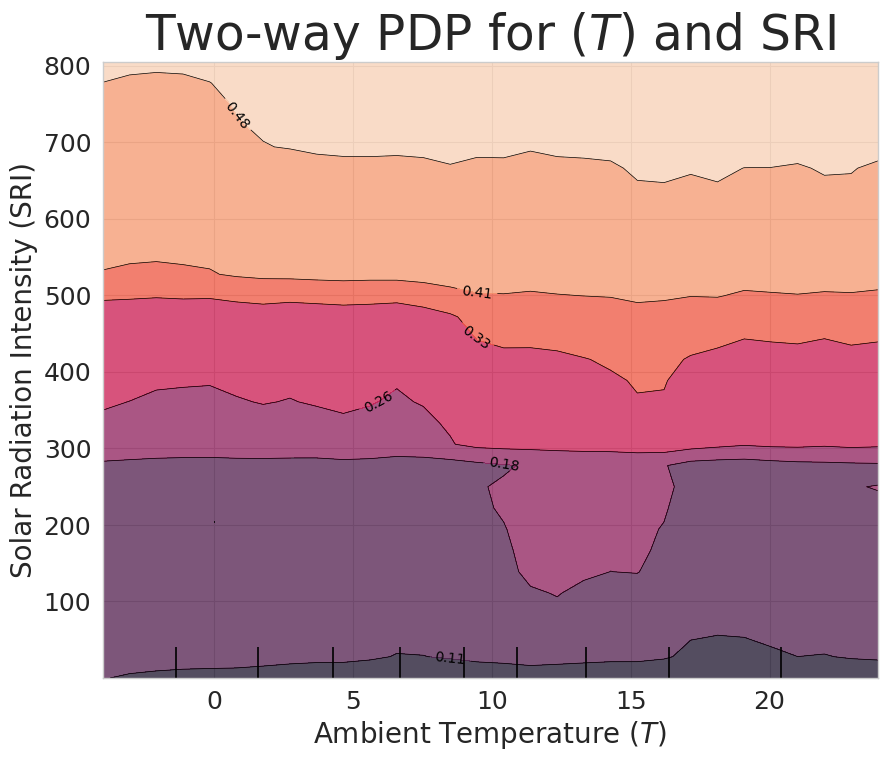

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

#feature_columns = ['total_N_conc_nanosmps', 'total_N_conc_smps','geometric_mean_smps']
feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                   'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                   'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']
friendly_names = [
        'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{tot}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]
#friendly_names = [
#    'test1',
#    'test2',
#    'test3',
#]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Set global parameters for font size using rcParams
plt.rcParams.update({'font.size': 27})  # Adjust font size globally

# Generate a two-way Partial Dependence Plot for Ambient Temperature and Solar Radiation Intensity
fig, ax = plt.subplots(figsize=(10, 8))
features_to_plot = [friendly_names.index('Ambient Temperature ($T$)'), friendly_names.index('Solar Radiation Intensity (SRI)')]
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)

# Set individual element sizes
ax.xaxis.set_major_locator(plt.MultipleLocator(100))  # Set major ticks interval
ax.tick_params(axis='both', labelsize=27)  # Ensure tick label size
#ax.set_xlabel('SRI (W m$^{-2}$)', fontsize=32)  # Increase font size of the x-axis label
#ax.set_ylabel('$T$ (°C)', fontsize=32)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for ($T$) and SRI', fontsize=35)
plt.show()


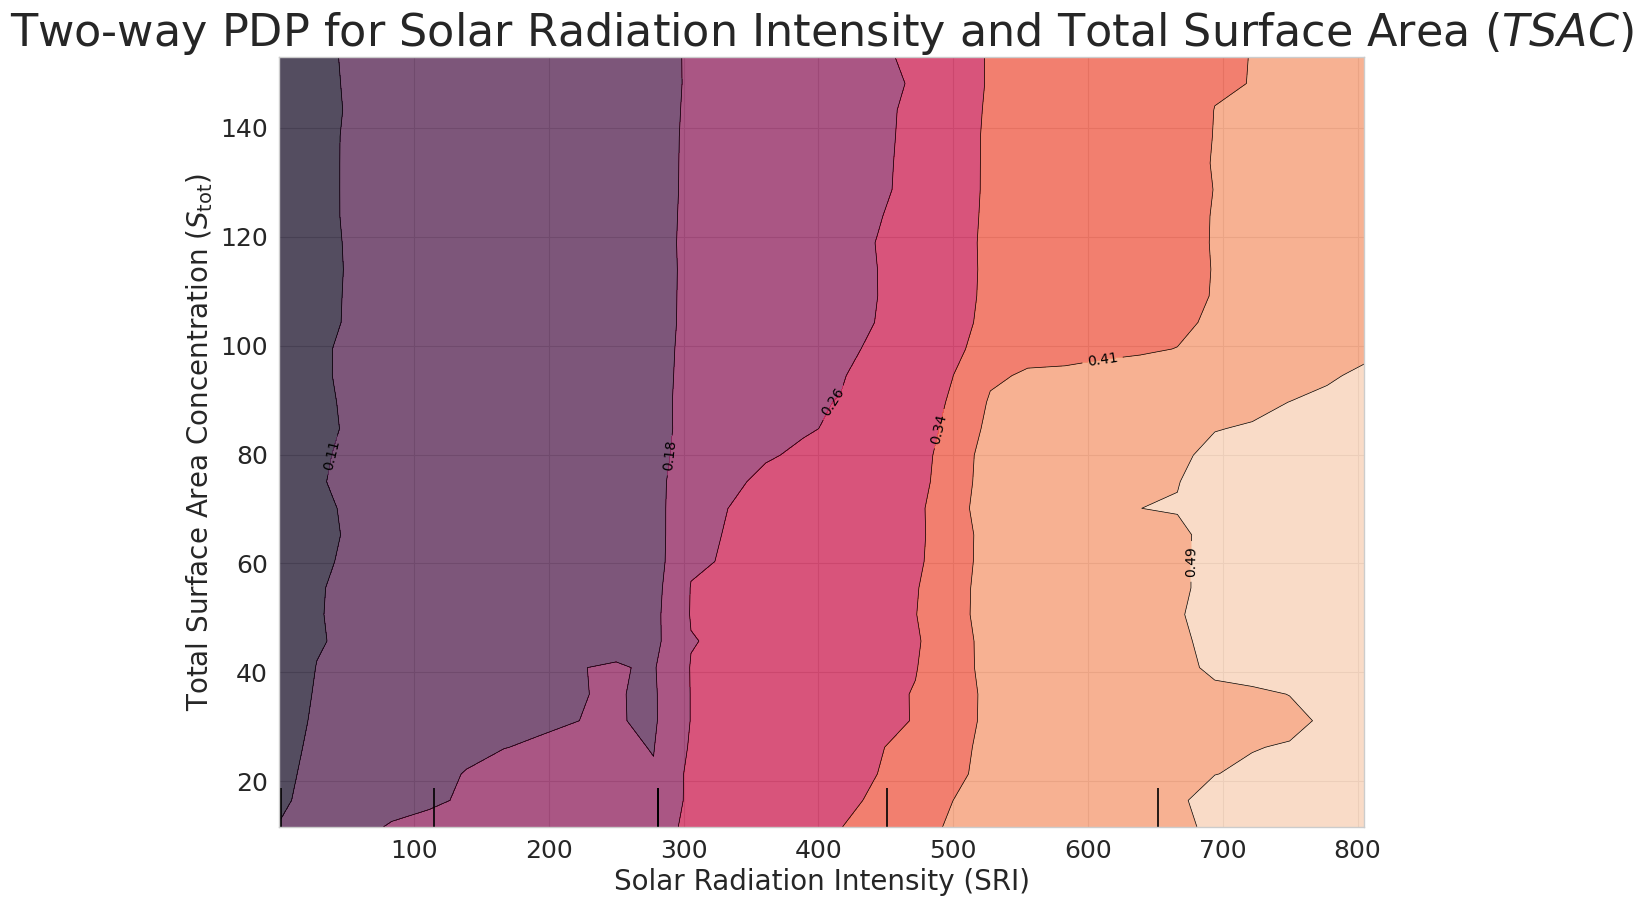

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X, y):
    return r2_score(y, model.predict(X))

feature_columns = ['bl_height_1_interp', 'total_organics_interp', 'sulfate_interp', 'nitrate_interp',
                    'rh_ambient_interp', 'temperature_ambient_interp', 'wind_direction_interp',
                    'wind_speed_interp', 'total_SA_conc_smps_interp', 'so2_interp',
                    'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp']

# Friendly names for plot labels
friendly_names = [
    'Boundary Layer Height (BLH)', 'Total Organics (Organics)', 'Sulfate (Sulfate)', 'Nitrate (Nitrate)',
    'Relative Humidity (RH)', 'Ambient Temperature ($T$)', 'Wind Direction (Wdir)',
    'Wind Speed (Wsp)', 'Total Surface Area Concentration ($S_{\mathrm{tot}}$)', 'Sulfur Dioxide (SO_2)',
    'Turbulent Kinetic Energy (TKE)', 'Solar Radiation Intensity (SRI)'
]

X = Dat[feature_columns]
y = Dat['flag3']

# Impute missing values with the mean for each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Reframe X_imputed as a DataFrame with friendly names for better plot labels
X_imputed_df = pd.DataFrame(X_imputed, columns=friendly_names)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed_df, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)

# Set global parameters for font size using rcParams
plt.rcParams.update({'font.size': 22})  # Adjust font size globally

# Generate a two-way Partial Dependence Plot for Ambient Temperature and Solar Radiation Intensity
fig, ax = plt.subplots(figsize=(14, 10))
features_to_plot = [friendly_names.index('Solar Radiation Intensity (SRI)'), friendly_names.index('Total Surface Area Concentration ($S_{\mathrm{tot}}$)')]
PartialDependenceDisplay.from_estimator(rf, X_train, features=[features_to_plot], feature_names=friendly_names, ax=ax, grid_resolution=30)

# Set individual element sizes
ax.xaxis.set_major_locator(plt.MultipleLocator(100))  # Set major ticks interval
ax.tick_params(axis='both', labelsize=22)  # Ensure tick label size
ax.set_xlabel('Solar Radiation Intensity (SRI)', fontsize=30)  # Increase font size of the x-axis label
ax.set_ylabel('Total Surface Area ($TSAC$)', fontsize=30)  # Increase font size of the y-axis label
ax.set_title('Two-way PDP for Solar Radiation Intensity and Total Surface Area ($TSAC$)', fontsize=32)
plt.show()


In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(model, X_train, y_train):
    return r2_score(y_train, model.predict(X_train))

# Calculate permutation importance
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

# Normalize the importance scores
perm_imp_rfpimp['Importance'] = perm_imp_rfpimp['Importance'] / perm_imp_rfpimp['Importance'].sum()

print(perm_imp_rfpimp)


                                                    Importance
Feature                                                       
Solar Radiation Intensity (SRI)                       0.326299
Relative Humidity (RH)                                0.254870
Ambient Temperature ($T$)                             0.114042
Total Surface Area Concentration ($S_{\mathrm{t...    0.092938
Turbulent Kinetic Energy (TKE)                        0.082386
Wind Speed (Wsp)                                      0.032873
Boundary Layer Height (BLH)                           0.025162
Wind Direction (Wdir)                                 0.023133
Nitrate (Nitrate)                                     0.021510
Total Organics (Organics)                             0.014610
Sulfate (Sulfate)                                     0.010146
Sulfur Dioxide (SO_2)                                 0.002029


## **SMOTE**

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load your data
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
X = df.drop(columns=['flag3'])  # Replace 'flag3' if your target column name is different
y = df['flag3']

# Fill missing values
X = X.fillna(X.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Train Random Forest with GridSearchCV (focus on F1-score)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = grid.best_estimator_

# Predictions on test set
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]


# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Confusion Matrix:
[[19063   197]
 [   80  5281]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19260
           1       0.96      0.99      0.97      5361

    accuracy                           0.99     24621
   macro avg       0.98      0.99      0.98     24621
weighted avg       0.99      0.99      0.99     24621

ROC AUC Score: 0.9991


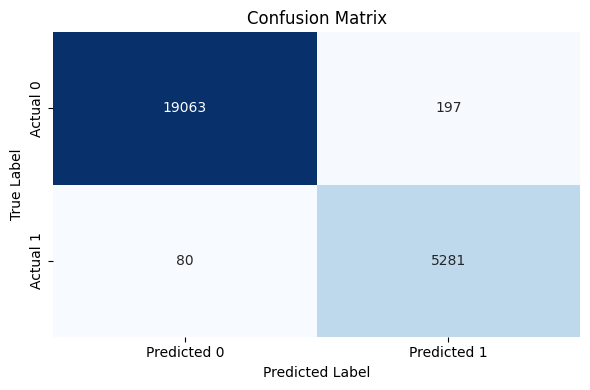

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['flag3'] = correct_isolated_values(df, 'flag3')

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

train_df = df[df['date'] < 20230101].copy()
test_df = df[df['date'] >= 20230101].copy()

train_df['flag3_shifted'] = shift_flag_sequences_yw(train_df, 'flag3', row_number=24, upnumbers=12)

X_train = train_df[features_columns].fillna(train_df[features_columns].mean())
y_train = train_df['flag3_shifted']

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

X_test = test_df[features_columns].fillna(test_df[features_columns].mean())
y_test = test_df['flag3']

model = RandomForestClassifier (n_estimators = 100,
                                n_jobs = -1,
                                oob_score = True,
                                bootstrap = True,
                                random_state = 42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      9453
           1       0.13      0.18      0.15      2643

    accuracy                           0.54     12096
   macro avg       0.43      0.41      0.42     12096
weighted avg       0.60      0.54      0.57     12096



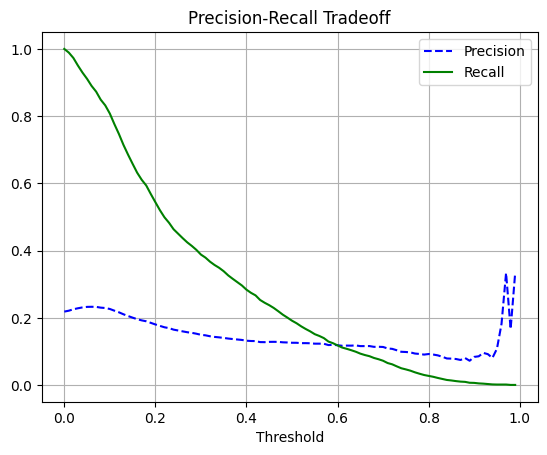

In [ ]:
from sklearn.metrics import precision_recall_curve

y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall vs. Threshold
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision-Recall Tradeoff')
plt.grid()
plt.show()

In [ ]:
y_pred_custom = (y_proba > 0.3).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.69      0.39      0.50      9453
           1       0.15      0.38      0.21      2643

    accuracy                           0.39     12096
   macro avg       0.42      0.38      0.36     12096
weighted avg       0.57      0.39      0.44     12096



In [ ]:
for t in [0.2, 0.25, 0.3, 0.35, 0.4]:
    y_pred = (y_proba > t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y_test, y_pred))

Threshold: 0.2
              precision    recall  f1-score   support

           0       0.70      0.32      0.44      9453
           1       0.18      0.52      0.26      2643

    accuracy                           0.36     12096
   macro avg       0.44      0.42      0.35     12096
weighted avg       0.59      0.36      0.40     12096

Threshold: 0.25
              precision    recall  f1-score   support

           0       0.69      0.36      0.47      9453
           1       0.16      0.44      0.23      2643

    accuracy                           0.37     12096
   macro avg       0.43      0.40      0.35     12096
weighted avg       0.58      0.37      0.42     12096

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.69      0.39      0.50      9453
           1       0.15      0.38      0.21      2643

    accuracy                           0.39     12096
   macro avg       0.42      0.38      0.36     12096
weighted avg       0.57     

In [ ]:
def mark_pre_npf_signal(df, flag_column='flag3', window=2):
    """
    Mark 'window' steps before each NPF onset as 1, everything else is 0.
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i-1] == 0:
            # NPF onset at i → mark previous 'window' steps
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=12)  # e.g., 1 hour before if 5-min data

# Then train model to predict npf_signal, not flag3
X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']



In [ ]:

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define isolated-value cleaner
def correct_isolated_values(df, col='flag3'):
    corrected = df[col].copy()
    for i in range(1, len(df) - 1):
        if df[col].iloc[i-1] == 0 and df[col].iloc[i+1] == 0 and df[col].iloc[i] == 1:
            corrected.iloc[i] = 0
    return corrected

# New: Mark only N steps before NPF onset as signal

def mark_pre_npf_signal(df, flag_column='flag3', window=12):
    """
    Marks the 'window' steps before each NPF onset as 1. All else 0.
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# Load data
Dat = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
Dat['flag3'] = correct_isolated_values(Dat, 'flag3')

# Feature list
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Split data
train_df = Dat[Dat['date'] < 20230101].copy()
test_df = Dat[Dat['date'] >= 20230101].copy()

# Mark pre-NPF signal (e.g., 1 hour = 12 steps before)
train_df['npf_signal'] = mark_pre_npf_signal(train_df, 'flag3', window=12)

# Prepare features + target
X_train = train_df[features_columns].fillna(train_df[features_columns].mean())
y_train = train_df['npf_signal']

# Apply SMOTE to balance signal
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# STEP 4: Prepare test set (no SMOTE)
X_test = test_df[features_columns].fillna(test_df[features_columns].mean())
y_test = test_df['flag3']  # actual events for evaluation

# STEP 5: Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# STEP 6: Predict and evaluate
y_pred = model.predict(X_test)
print("\nClassification Report (against actual flag3):")
print(classification_report(y_test, y_pred))



Classification Report (against actual flag3):
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      9453
           1       0.35      0.12      0.17      2643

    accuracy                           0.76     12096
   macro avg       0.57      0.53      0.52     12096
weighted avg       0.70      0.76      0.71     12096



In [ ]:

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define isolated-value cleaner
def correct_isolated_values(df, col='flag3'):
    corrected = df[col].copy()
    for i in range(1, len(df) - 1):
        if df[col].iloc[i-1] == 0 and df[col].iloc[i+1] == 0 and df[col].iloc[i] == 1:
            corrected.iloc[i] = 0
    return corrected

# New: Mark only N steps before NPF onset as signal

def mark_pre_npf_signal(df, flag_column='flag3', window=12):
    """
    Marks the 'window' steps before each NPF onset as 1. All else 0.
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# Load data
Dat = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
Dat['flag3'] = correct_isolated_values(Dat, 'flag3')

# Feature list
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Split data
train_df = Dat[Dat['date'] < 20230101].copy()
test_df = Dat[Dat['date'] >= 20230101].copy()

# Mark pre-NPF signal (e.g., 1/2 hour = 6 steps before)
train_df['npf_signal'] = mark_pre_npf_signal(train_df, 'flag3', window = 3)

# Prepare features + target
X_train = train_df[features_columns].fillna(train_df[features_columns].mean())
y_train = train_df['npf_signal']

# Apply SMOTE to balance signal
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Prepare test set (no SMOTE)
X_test = test_df[features_columns].fillna(test_df[features_columns].mean())
y_test = test_df['flag3']  # actual events for evaluation

# Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
print("\nClassification Report (against actual flag3):")
print(classification_report(y_test, y_pred))



Classification Report (against actual flag3):
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      9453
           1       0.50      0.04      0.07      2643

    accuracy                           0.78     12096
   macro avg       0.64      0.51      0.48     12096
weighted avg       0.72      0.78      0.70     12096



In [ ]:

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define isolated-value cleaner
def correct_isolated_values(df, col='flag3'):
    corrected = df[col].copy()
    for i in range(1, len(df) - 1):
        if df[col].iloc[i-1] == 0 and df[col].iloc[i+1] == 0 and df[col].iloc[i] == 1:
            corrected.iloc[i] = 0
    return corrected

# New: Mark only N steps before NPF onset as signal

def mark_pre_npf_signal(df, flag_column='flag3', window=12):
    """
    Marks the 'window' steps before each NPF onset as 1. All else 0.
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# Load data
Dat = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
Dat['flag3'] = correct_isolated_values(Dat, 'flag3')

# Feature list
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Split data
train_df = Dat[Dat['date'] < 20230101].copy()
test_df = Dat[Dat['date'] >= 20230101].copy()

# Mark pre-NPF signal (e.g., 2 hour = 24 steps before)
train_df['npf_signal'] = mark_pre_npf_signal(train_df, 'flag3', window = 24)

# Prepare features + target
X_train = train_df[features_columns].fillna(train_df[features_columns].mean())
y_train = train_df['npf_signal']

# Apply SMOTE to balance signal
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Prepare test set (no SMOTE)
X_test = test_df[features_columns].fillna(test_df[features_columns].mean())
y_test = test_df['flag3']  # actual events for evaluation

# Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
print("\nClassification Report (against actual flag3):")
print(classification_report(y_test, y_pred))



Classification Report (against actual flag3):
              precision    recall  f1-score   support

           0       0.77      0.70      0.74      9453
           1       0.20      0.26      0.22      2643

    accuracy                           0.61     12096
   macro avg       0.48      0.48      0.48     12096
weighted avg       0.65      0.61      0.62     12096



In [ ]:
#Read in data
#Dat = pd.read_csv(r'F:\NPF_ML\model_ready_data\aligned_data_2018_2023_all_11202024.csv')
#Dat = pd.read_csv('/Volumes/PMTL_MODEL/NPF_ML/model_ready_data/aligned_data_2018_2023_all_11202024.csv')
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 1: Define helper functions

# Clean isolated flag3 == 1 spikes
def correct_isolated_values(df, col='flag3'):
    corrected = df[col].copy()
    for i in range(1, len(df) - 1):
        if df[col].iloc[i-1] == 0 and df[col].iloc[i+1] == 0 and df[col].iloc[i] == 1:
            corrected.iloc[i] = 0
    return corrected

# Create early-warning labels (pre-NPF)
def mark_pre_npf_signal(df, flag_column='flag3', window=24):
    """
    Marks the `window` steps before each NPF onset as 1 (early warning).
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name=f'npf_signal_{window}')

# Step 2: Load and prepare data
Dat = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
Dat['flag3'] = correct_isolated_values(Dat, 'flag3')

# Step 3: Feature list
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Step 4: Train/test split
train_df = Dat[Dat['date'] < 20230101].copy()
test_df = Dat[Dat['date'] >= 20230101].copy()

# Step 5: Mark 2-hour early warning label (can change window=12, 36, etc.)
train_df['npf_signal'] = mark_pre_npf_signal(train_df, 'flag3', window=12)

# Step 6: Prepare X and y
X_train = train_df[features_columns].fillna(train_df[features_columns].mean())
y_train = train_df['npf_signal']

# Step 7: SMOTE only on training
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Step 8: Prepare test data
X_test = test_df[features_columns].fillna(test_df[features_columns].mean())
y_test = test_df['flag3']  # Ground truth: actual NPF events

# Step 9: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Step 10: Predict and evaluate
y_pred = model.predict(X_test)
print("\nClassification Report (predicting pre-NPF, evaluated against actual NPF):")
print(classification_report(y_test, y_pred))



Classification Report (predicting pre-NPF, evaluated against actual NPF):
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      9453
           1       0.35      0.12      0.17      2643

    accuracy                           0.76     12096
   macro avg       0.57      0.53      0.52     12096
weighted avg       0.70      0.76      0.71     12096



In [ ]:


# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Step 1: Mark pre-NPF warning zones
def mark_pre_npf_signal(df, flag_column='flag3', window=24):
    """
    Marks the `window` steps before each NPF onset (flag3 goes from 0 → 1) as 1.
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name=f'npf_signal_{window}')

# Step 2: Load your data
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

# Step 3: Create pre-NPF signal (e.g. 2 hours = 24 steps)
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=24)

# Step 4: Define features and labels
X = df.drop(columns=['flag3', 'npf_signal'])
y = df['npf_signal']

# Step 5: Handle missing data
X = X.fillna(X.mean())

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Step 7: Apply SMOTE to training set only
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Step 8: Define parameter grid for tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Step 9: Train with GridSearchCV
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

# Step 10: Evaluate on test set
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[20904  1494]
 [  122  2101]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     22398
         1.0       0.58      0.95      0.72      2223

    accuracy                           0.93     24621
   macro avg       0.79      0.94      0.84     24621
weighted avg       0.96      0.93      0.94     24621

ROC AUC Score: 0.9779


In [ ]:


# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Step 1: Mark pre-NPF warning zones
def mark_pre_npf_signal(df, flag_column='flag3', window=24):
    """
    Marks the `window` steps before each NPF onset (flag3 goes from 0 → 1) as 1.
    """
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name=f'npf_signal_{window}')

# Step 2: Load your data
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

# Step 3: Create pre-NPF signal (e.g. 2 hours = 24 steps)
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=12)

# Step 4: Define features and labels
X = df.drop(columns=['flag3', 'npf_signal'])
y = df['npf_signal']

# Step 5: Handle missing data
X = X.fillna(X.mean())

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Step 7: Apply SMOTE to training set only
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Step 8: Define parameter grid for tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Step 9: Train with GridSearchCV
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

# Step 10: Evaluate on test set
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[21823  1671]
 [   94  1033]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     23494
         1.0       0.38      0.92      0.54      1127

    accuracy                           0.93     24621
   macro avg       0.69      0.92      0.75     24621
weighted avg       0.97      0.93      0.94     24621

ROC AUC Score: 0.9682


In [ ]:


  # Imports
  import pandas as pd
  import numpy as np
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import train_test_split, GridSearchCV
  from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
  from imblearn.over_sampling import SMOTE

  # Step 1: Mark pre-NPF warning zones
  def mark_pre_npf_signal(df, flag_column='flag3', window=24):
      """
      Marks the `window` steps before each NPF onset (flag3 goes from 0 → 1) as 1.
      """
      signal = np.zeros(len(df))
      for i in range(1, len(df)):
          if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
              start = max(0, i - window)
              signal[start:i] = 1
      return pd.Series(signal, index=df.index, name=f'npf_signal_{window}')

  # Step 2: Load your data
  df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

  # Step 3: Create pre-NPF signal (e.g. 3 hours = 36 steps)
  df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window= 36)

  # Step 4: Define features and labels
  X = df.drop(columns=['flag3', 'npf_signal'])
  y = df['npf_signal']

  # Step 5: Handle missing data
  X = X.fillna(X.mean())

  # Step 6: Train/test split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
  )

  # Step 7: Apply SMOTE to training set only
  sm = SMOTE(random_state=42)
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

  # Step 8: Define parameter grid for tuning
  param_grid = {
      'n_estimators': [100],
      'max_depth': [10],
      'min_samples_split': [2],
      'min_samples_leaf': [1]
  }

  # Step 9: Train with GridSearchCV
  rf = RandomForestClassifier(random_state=42, class_weight='balanced')
  grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
  grid.fit(X_train_resampled, y_train_resampled)

  # Step 10: Evaluate on test set
  best_rf = grid.best_estimator_
  y_pred = best_rf.predict(X_test)
  y_prob = best_rf.predict_proba(X_test)[:, 1]

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[20169  1142]
 [  150  3160]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     21311
         1.0       0.73      0.95      0.83      3310

    accuracy                           0.95     24621
   macro avg       0.86      0.95      0.90     24621
weighted avg       0.96      0.95      0.95     24621

ROC AUC Score: 0.9844


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[18555  2756]
 [  497  2813]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92     21311
         1.0       0.51      0.85      0.63      3310

    accuracy                           0.87     24621
   macro avg       0.74      0.86      0.78     24621
weighted avg       0.91      0.87      0.88     24621

ROC AUC Score: 0.9295


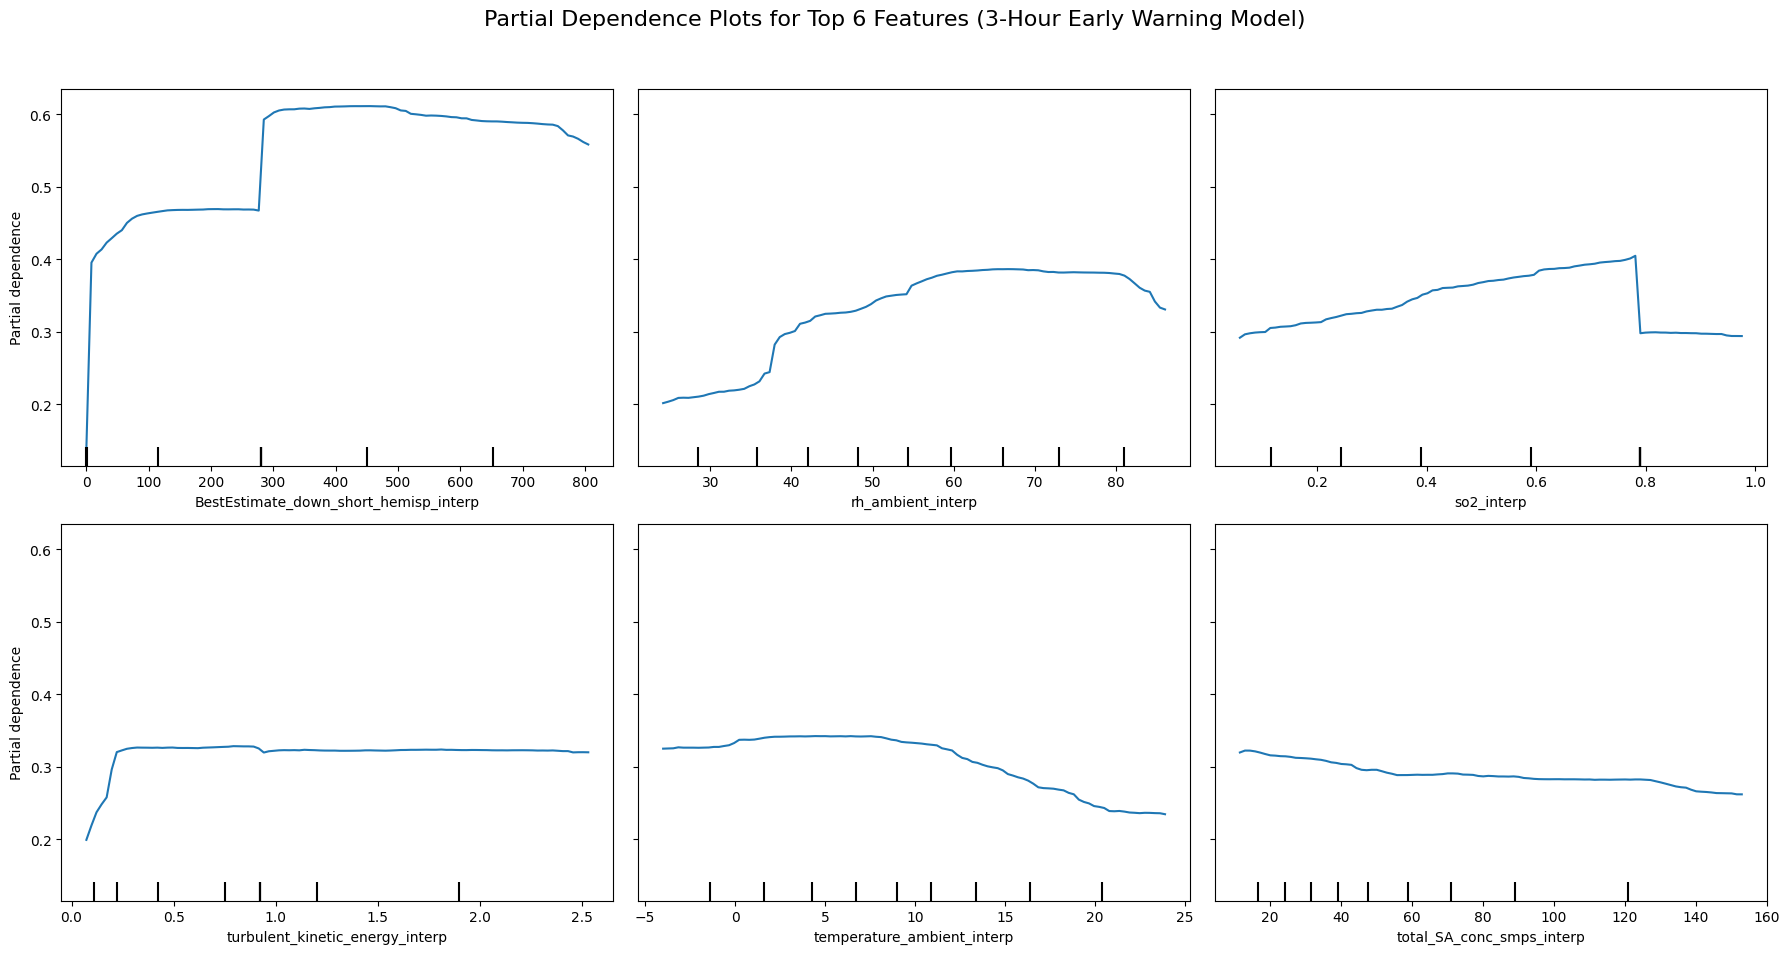

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

# Step 1: Define feature columns explicitly
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Step 2: Helper function to mark 3-hour early warning labels
def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# Step 3: Load data and create label
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=36)

# Step 4: Prepare X and y (only 12 selected features)
X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

# Step 5: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Apply SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Step 7: Train with GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

# Step 8: Evaluate model
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Step 9: Get feature importances
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 10: PDP for Top 6 Features
top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (3-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


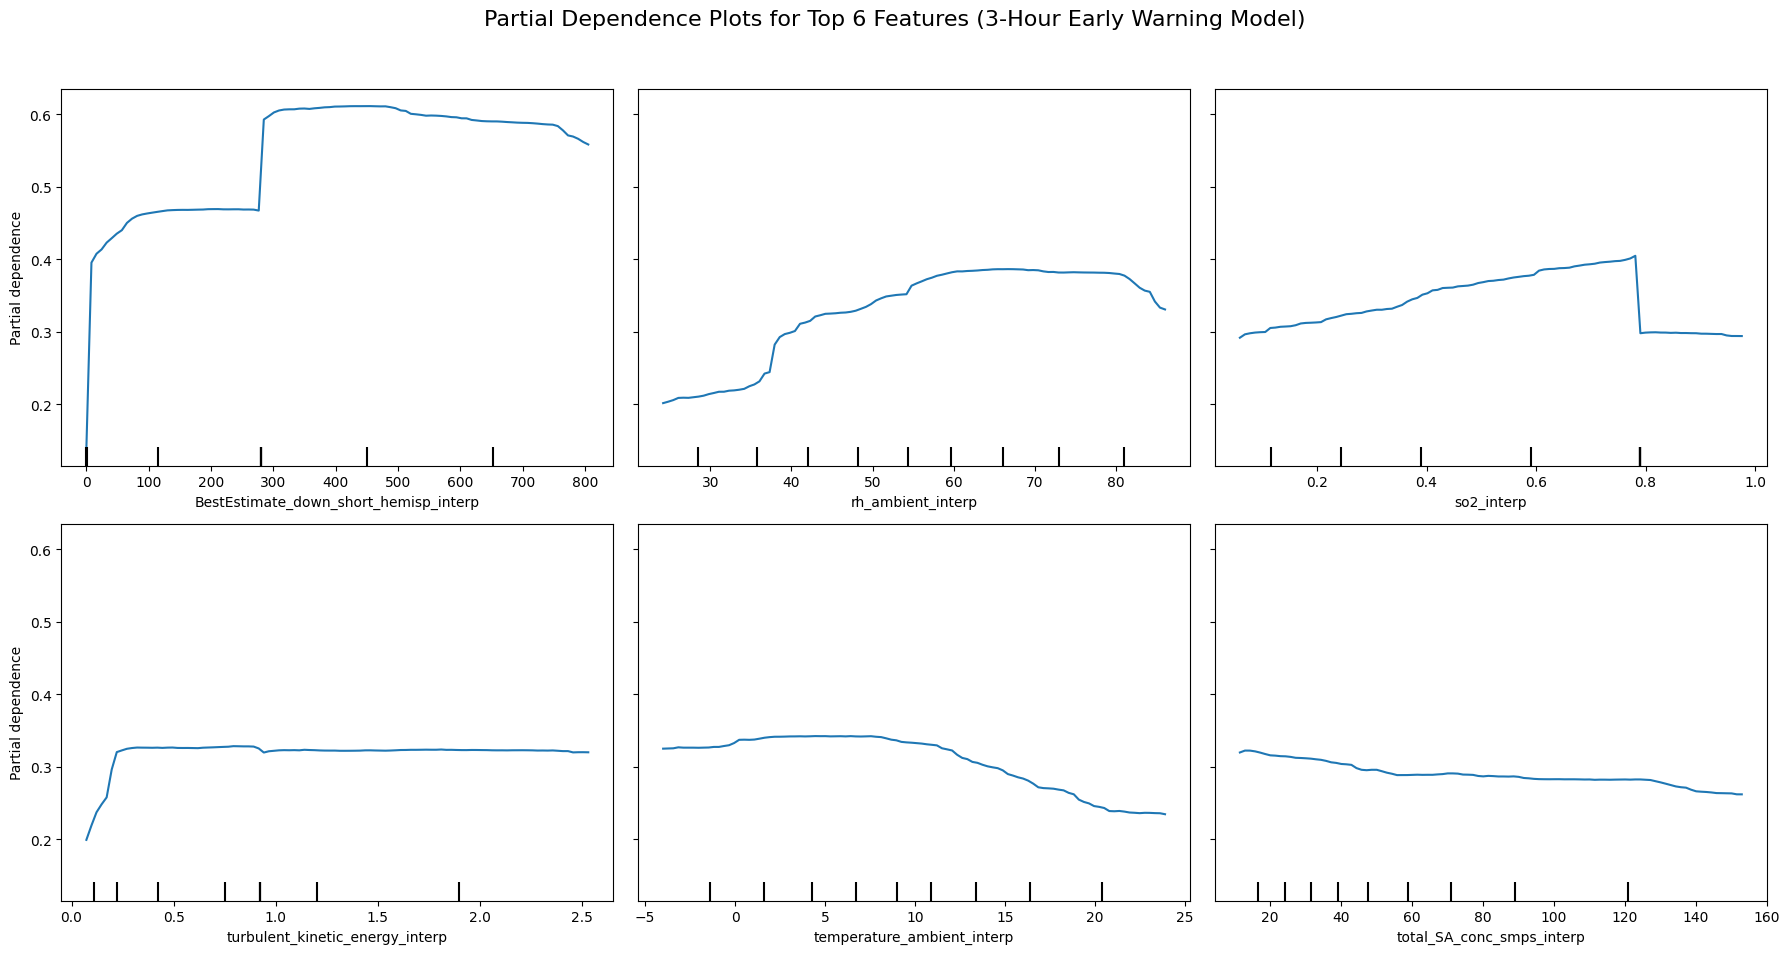

In [ ]:
# Step 9: Get feature importances
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 10: PDP for Top 6 Features
top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (3-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

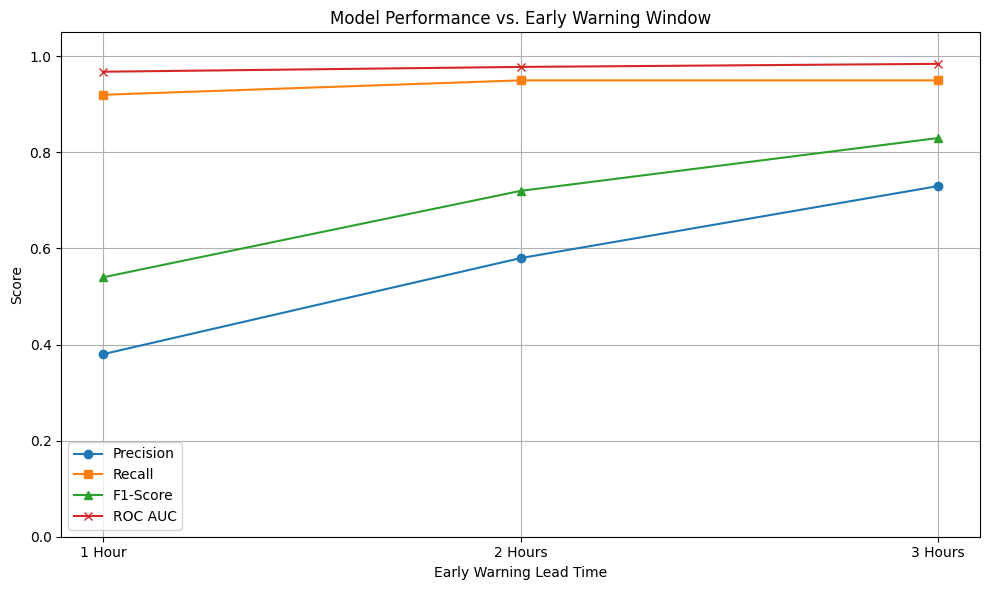

In [ ]:
import matplotlib.pyplot as plt

# Metric values from your 3 runs
windows = ['1 Hour', '2 Hours', '3 Hours']
precision = [0.38, 0.58, 0.73]
recall =    [0.92, 0.95, 0.95]
f1_score =  [0.54, 0.72, 0.83]
roc_auc =   [0.968, 0.978, 0.9844]

plt.figure(figsize=(10, 6))
plt.plot(windows, precision, label='Precision', marker='o')
plt.plot(windows, recall, label='Recall', marker='s')
plt.plot(windows, f1_score, label='F1-Score', marker='^')
plt.plot(windows, roc_auc, label='ROC AUC', marker='x')

plt.title('Model Performance vs. Early Warning Window')
plt.xlabel('Early Warning Lead Time')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-12-1568915543>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


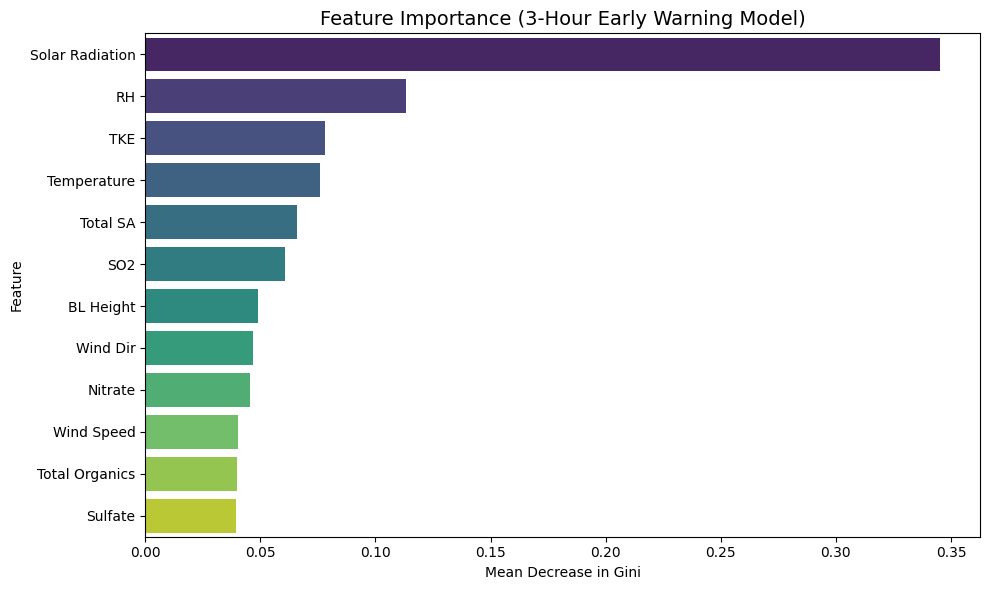

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Feature importance
importances = model.feature_importances_
feature_names = [
    'BL Height', 'Total Organics', 'Sulfate', 'Nitrate',
    'RH', 'Temperature', 'Wind Dir', 'Wind Speed',
    'Total SA', 'SO2', 'TKE', 'Solar Radiation'
]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (3-Hour Early Warning Model)', fontsize=14)
plt.xlabel('Mean Decrease in Gini')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Initial Top Features: ['time_hours', 'flag5', 'BestEstimate_down_short_hemisp_interp', 'total_N_conc_nanosmps', 'smoothed_arithmetic_mean_below_30', 'Particle_Size_10.2nm', 'Particle_Size_11.3nm', 'Particle_Size_10.9nm', 'flag2', 'Particle_Size_13.1nm']
Skipping 'flag5' due to PDP error: cannot reshape array of size 1 into shape (2)
✅ Final PDP-compatible features: ['time_hours', 'BestEstimate_down_short_hemisp_interp', 'total_N_conc_nanosmps', 'smoothed_arithmetic_mean_below_30', 'Particle_Size_10.2nm', 'Particle_Size_11.3nm']


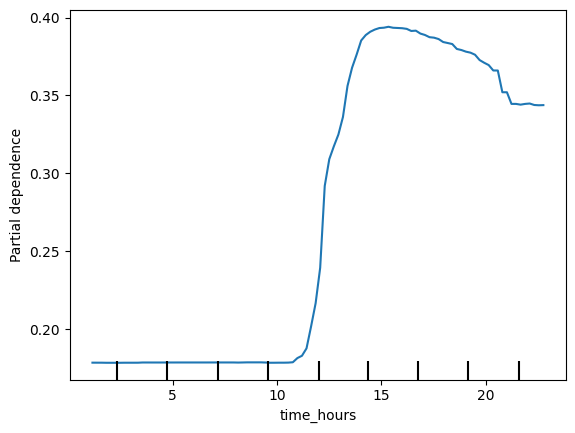

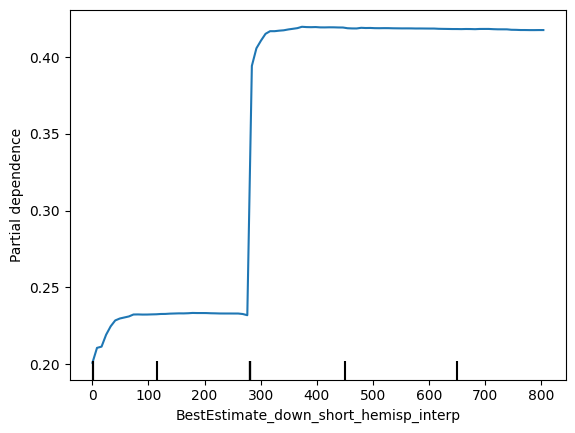

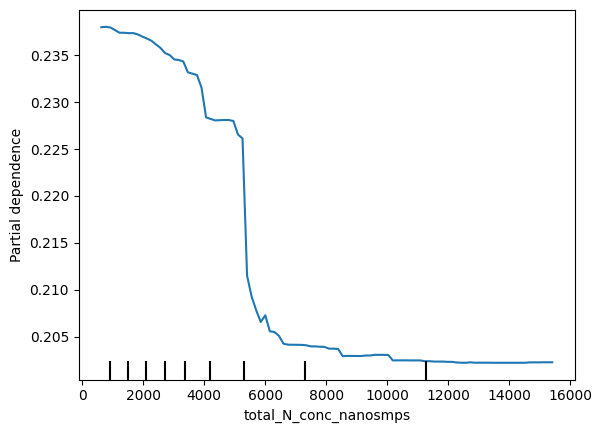

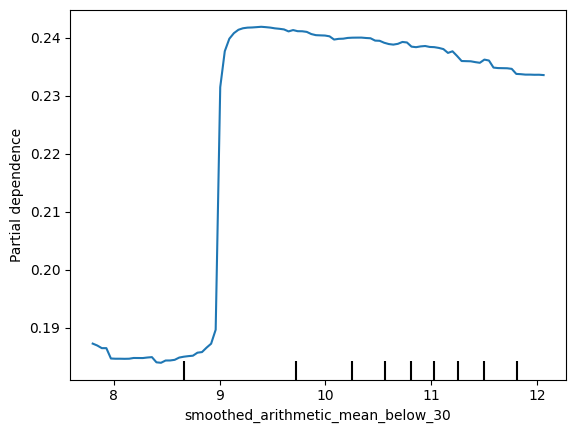

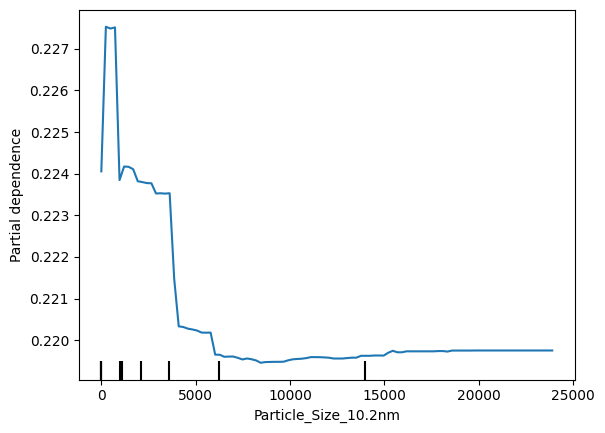

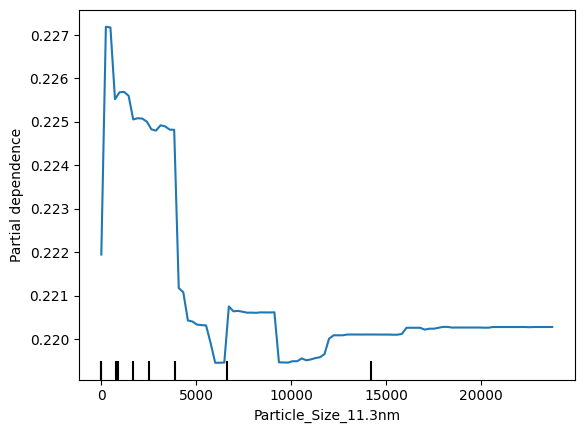

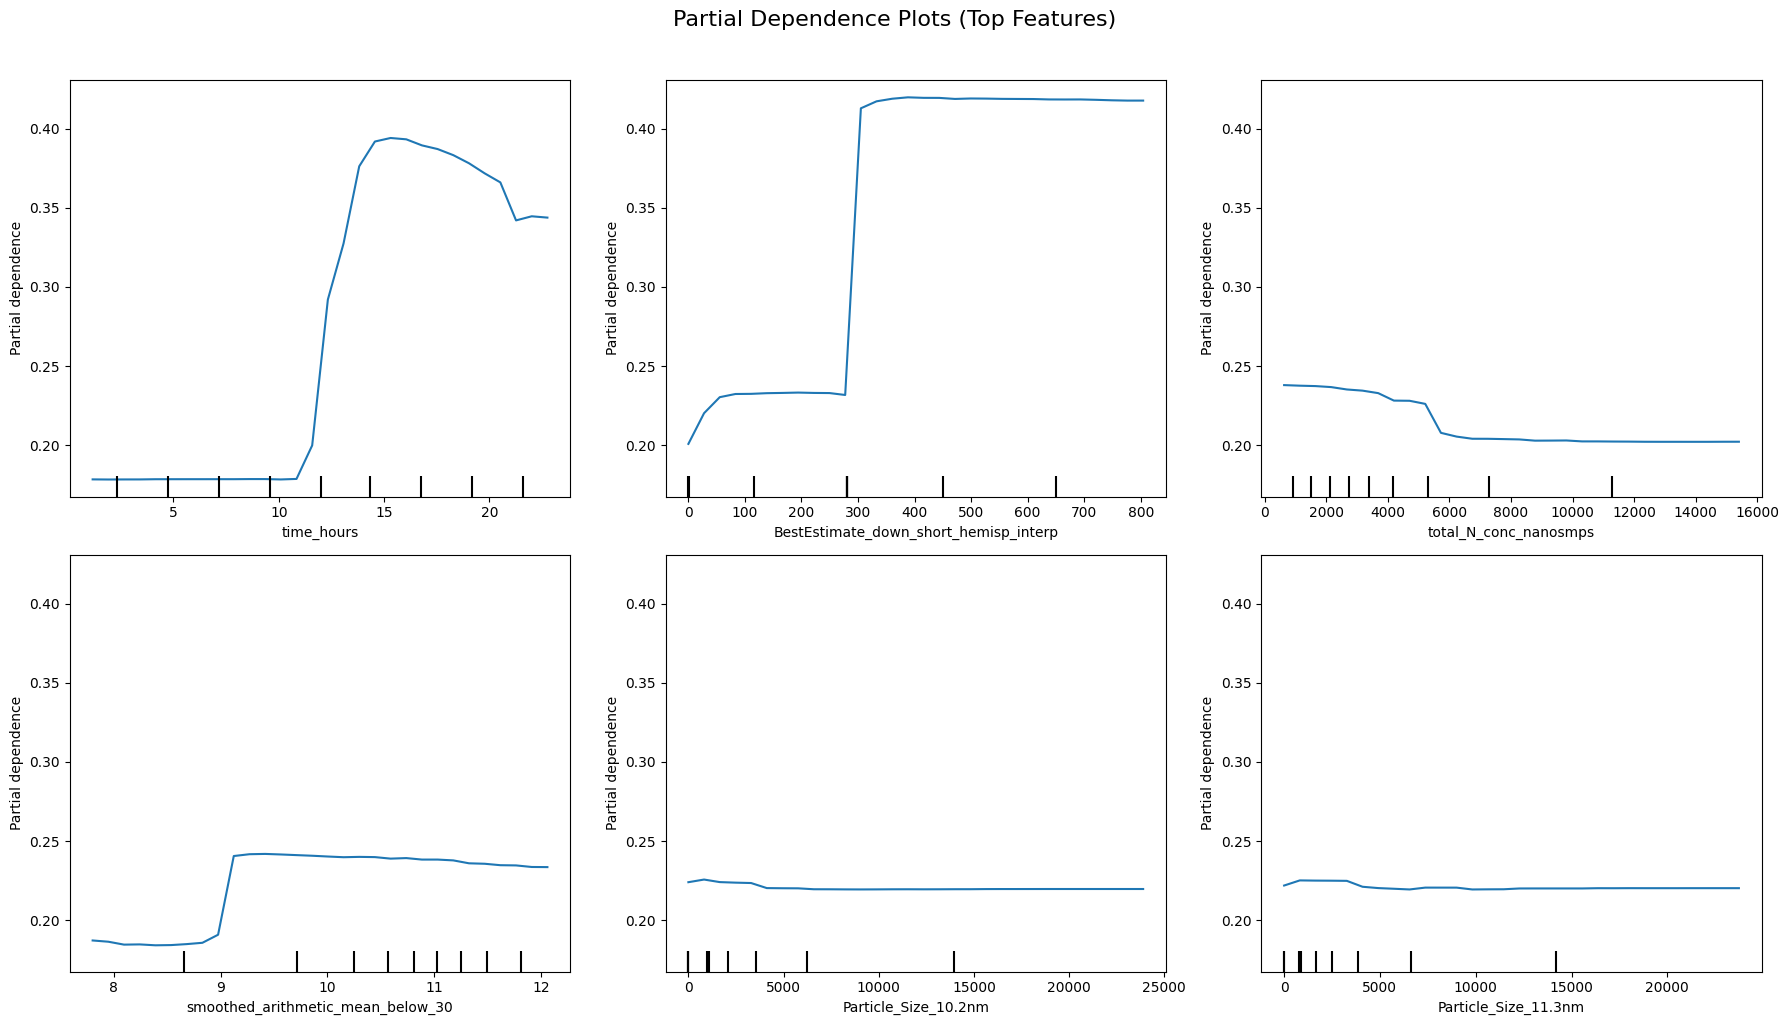

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Step 1: Feature importance
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 2: Get top 10 (in case some fail)
top_features = feature_importance_df['Feature'].head(10).tolist()
print("Initial Top Features:", top_features)

# Step 3: Filter numeric & non-constant features
valid_features = []
for feat in top_features:
    if pd.api.types.is_numeric_dtype(X[feat]) and X[feat].nunique() > 1:
        try:
            # Test PDP with one feature
            PartialDependenceDisplay.from_estimator(best_rf, X, [feat])
            valid_features.append(feat)
            if len(valid_features) == 6:
                break
        except Exception as e:
            print(f"Skipping '{feat}' due to PDP error: {e}")

print("✅ Final PDP-compatible features:", valid_features)

# Step 4: Plot valid PDPs
n = len(valid_features)
rows = (n + 2) // 3
fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(18, 5 * rows))

if isinstance(ax, np.ndarray):
    ax = ax.flatten()
else:
    ax = [ax]

PartialDependenceDisplay.from_estimator(
    best_rf, X, valid_features, grid_resolution=30, ax=ax[:n]
)

plt.suptitle('Partial Dependence Plots (Top Features)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving aligned_data_bnf.csv to aligned_data_bnf.csv


In [ ]:
# Install imbalanced-learn if not done
!pip install imbalanced-learn

# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. Helper function
def mark_pre_npf_signal(df, flag_column='flag3', window=36):  # 3 hours = 36 steps (5-min data)
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# 2. Load training data
df_train = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df_train['npf_signal'] = mark_pre_npf_signal(df_train, 'flag3', window=36)

# 3. Load test data
df_test = pd.read_csv('aligned_data_bnf.csv')
df_test['npf_signal'] = mark_pre_npf_signal(df_test, 'flag3', window=36)

# 4. Features (assumes same feature set in both files)
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# 5. Prepare data
X_train = df_train[features_columns].fillna(df_train[features_columns].mean())
y_train = df_train['npf_signal']

X_test = df_test[features_columns].fillna(df_test[features_columns].mean())
y_test = df_test['flag3']  # Evaluate against true event occurrence

# 6. Apply SMOTE on training
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 7. Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# 8. Predict on NEW test dataset
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 9. Evaluate
print("Confusion Matrix (Test Dataset):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (Test Dataset):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score (Test Dataset): {roc_auc_score(y_test, y_prob):.4f}")

KeyError: "['total_SA_conc_smps_interp', 'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'] not in index"

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[17316  2927]
 [  709  3669]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90     20243
         1.0       0.56      0.84      0.67      4378

    accuracy                           0.85     24621
   macro avg       0.76      0.85      0.79     24621
weighted avg       0.89      0.85      0.86     24621

ROC AUC Score: 0.9159


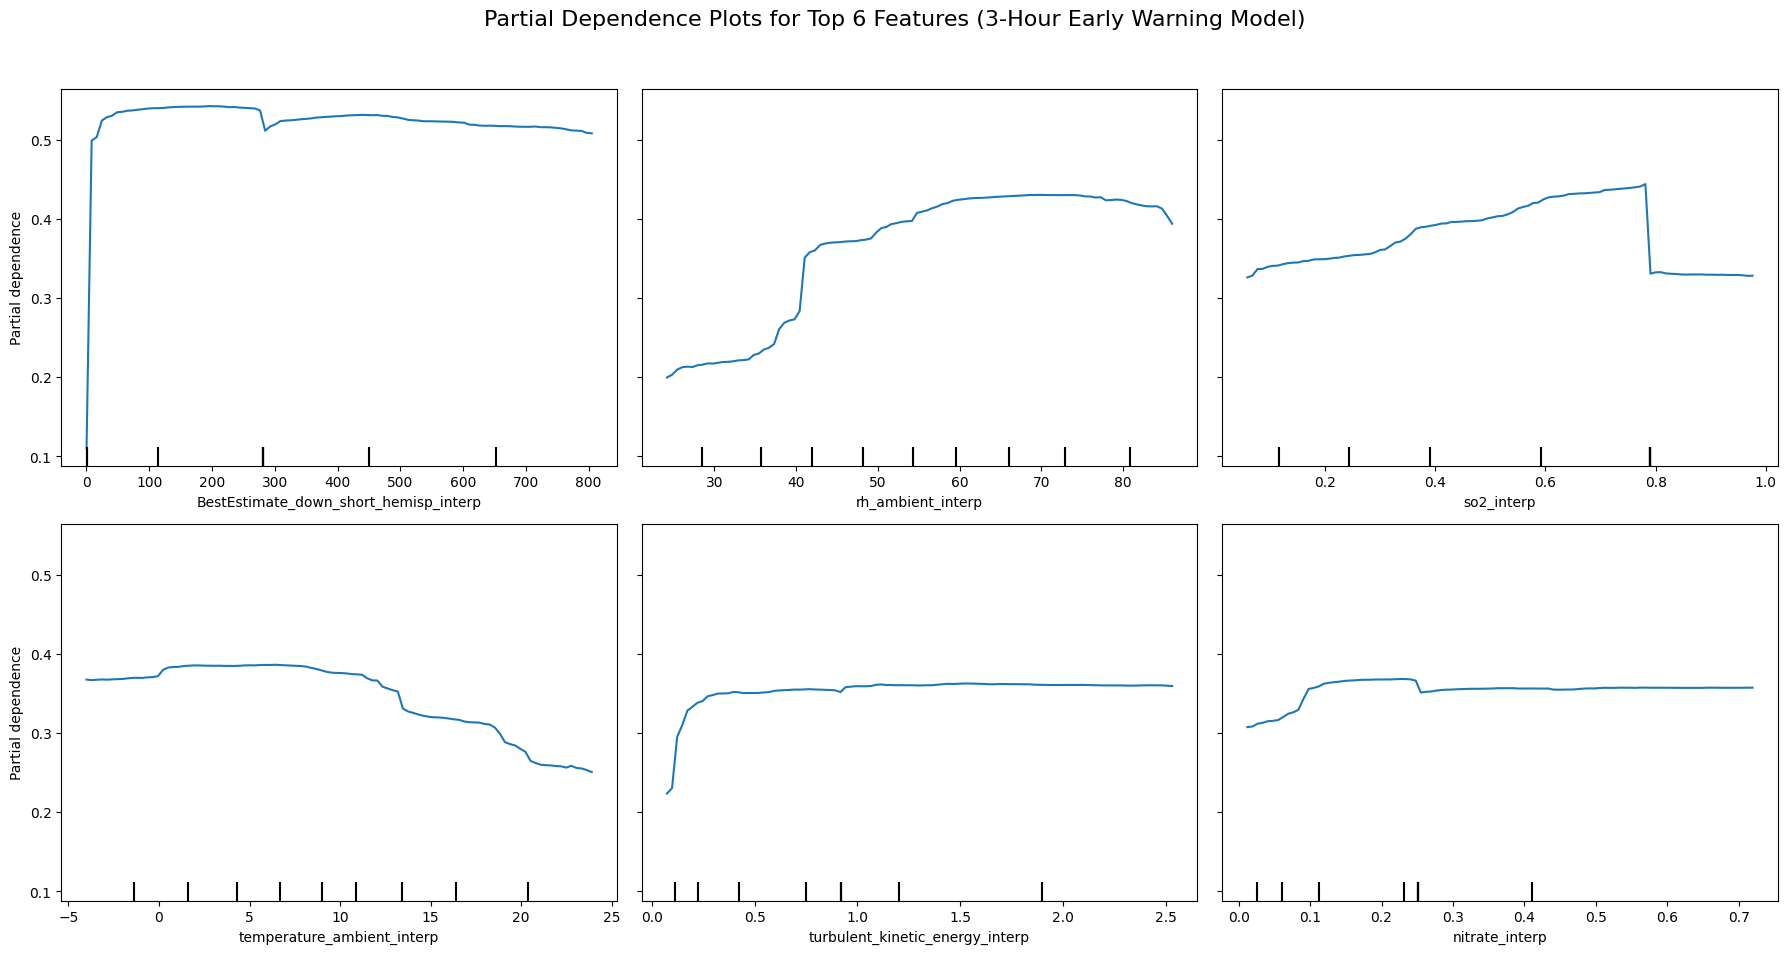

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=48):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')


df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=48)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (3-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[14793  3276]
 [ 1306  5246]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     18069
         1.0       0.62      0.80      0.70      6552

    accuracy                           0.81     24621
   macro avg       0.77      0.81      0.78     24621
weighted avg       0.84      0.81      0.82     24621

ROC AUC Score: 0.9009


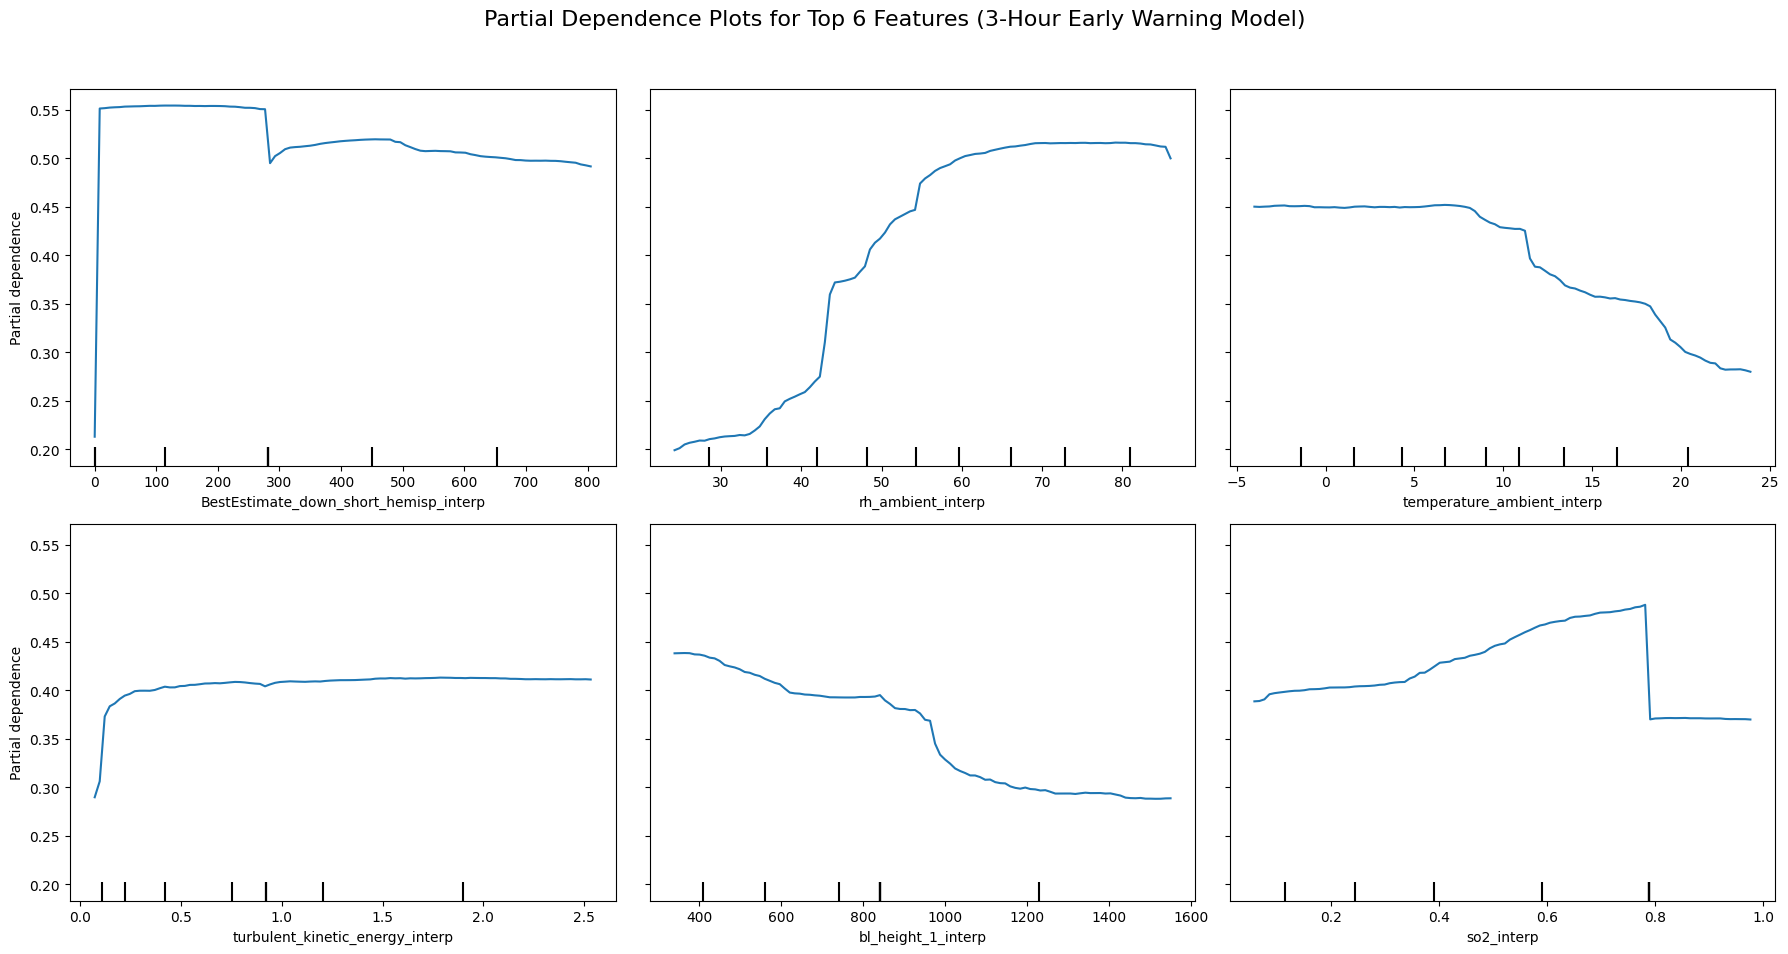

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

# Step 1: Define feature columns explicitly
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Step 2: Helper function to mark 3-hour early warning labels
def mark_pre_npf_signal(df, flag_column='flag3', window=72):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# Step 3: Load data and create label
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=72)

# Step 4: Prepare X and y (only 12 selected features)
X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

# Step 5: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Apply SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Step 7: Train with GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

# Step 8: Evaluate model
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Step 9: Get feature importances
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 10: PDP for Top 6 Features
top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (3-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[12374  3603]
 [ 1280  7364]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.84     15977
         1.0       0.67      0.85      0.75      8644

    accuracy                           0.80     24621
   macro avg       0.79      0.81      0.79     24621
weighted avg       0.82      0.80      0.81     24621

ROC AUC Score: 0.9023


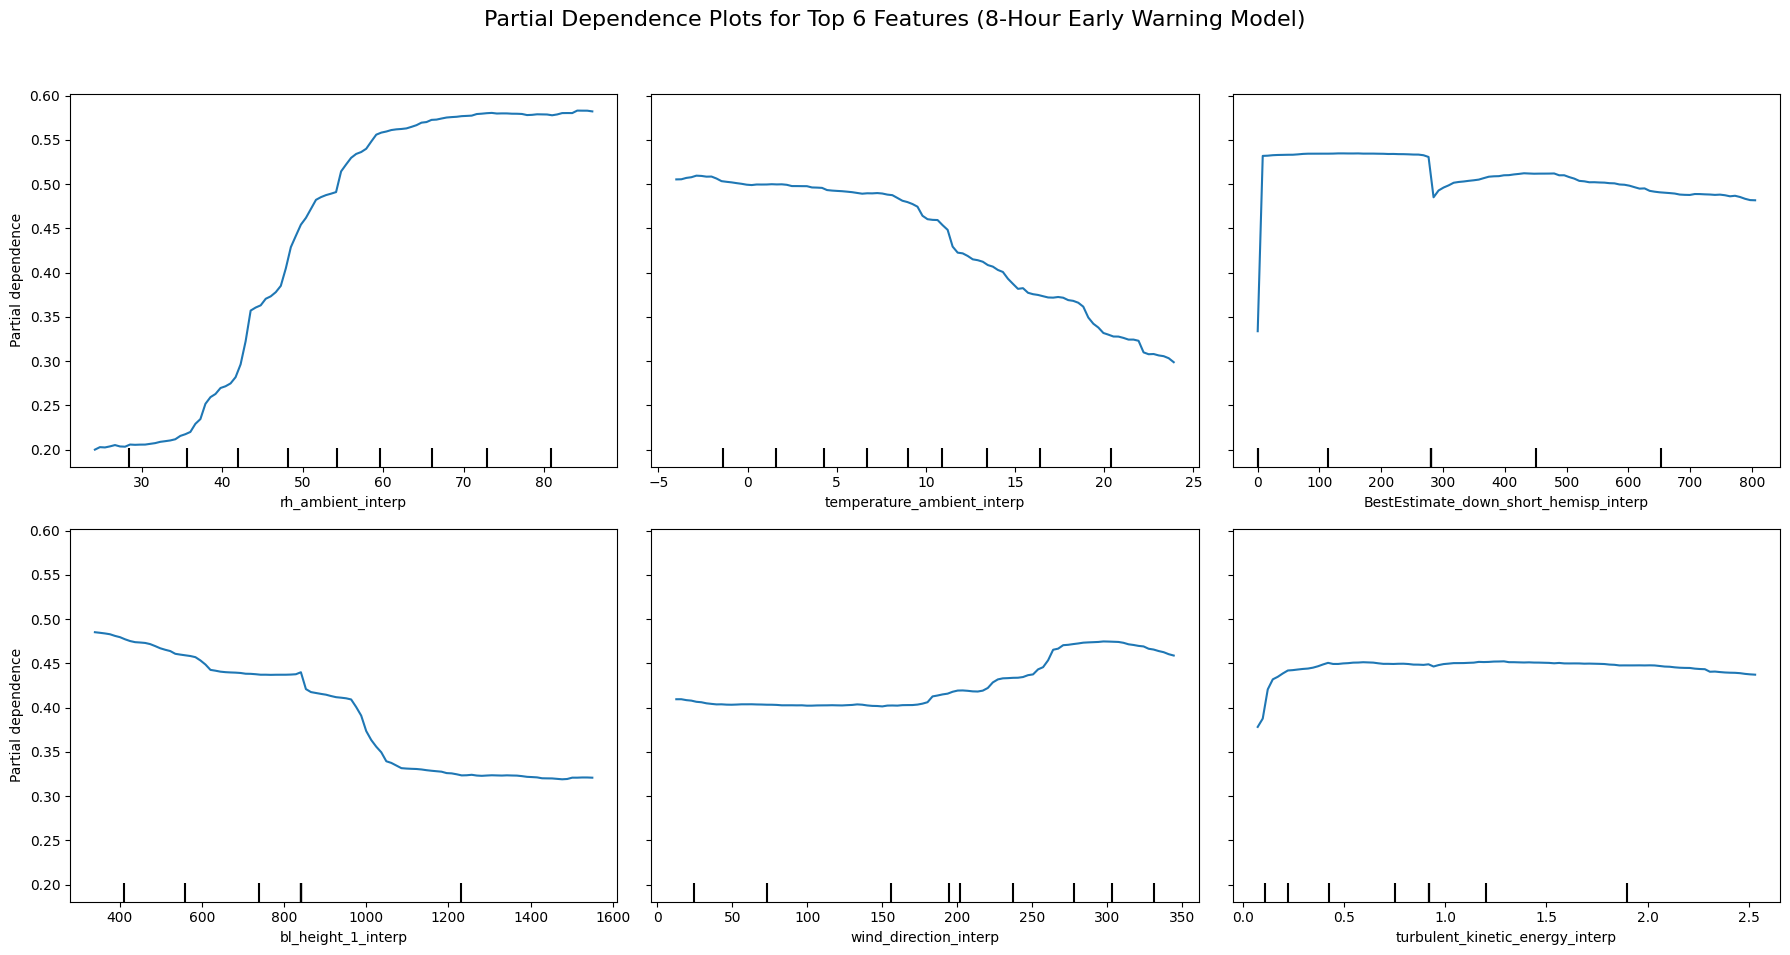

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=96):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=96)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (8-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[10589  3364]
 [ 1226  9442]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82     13953
         1.0       0.74      0.89      0.80     10668

    accuracy                           0.81     24621
   macro avg       0.82      0.82      0.81     24621
weighted avg       0.83      0.81      0.81     24621

ROC AUC Score: 0.9146


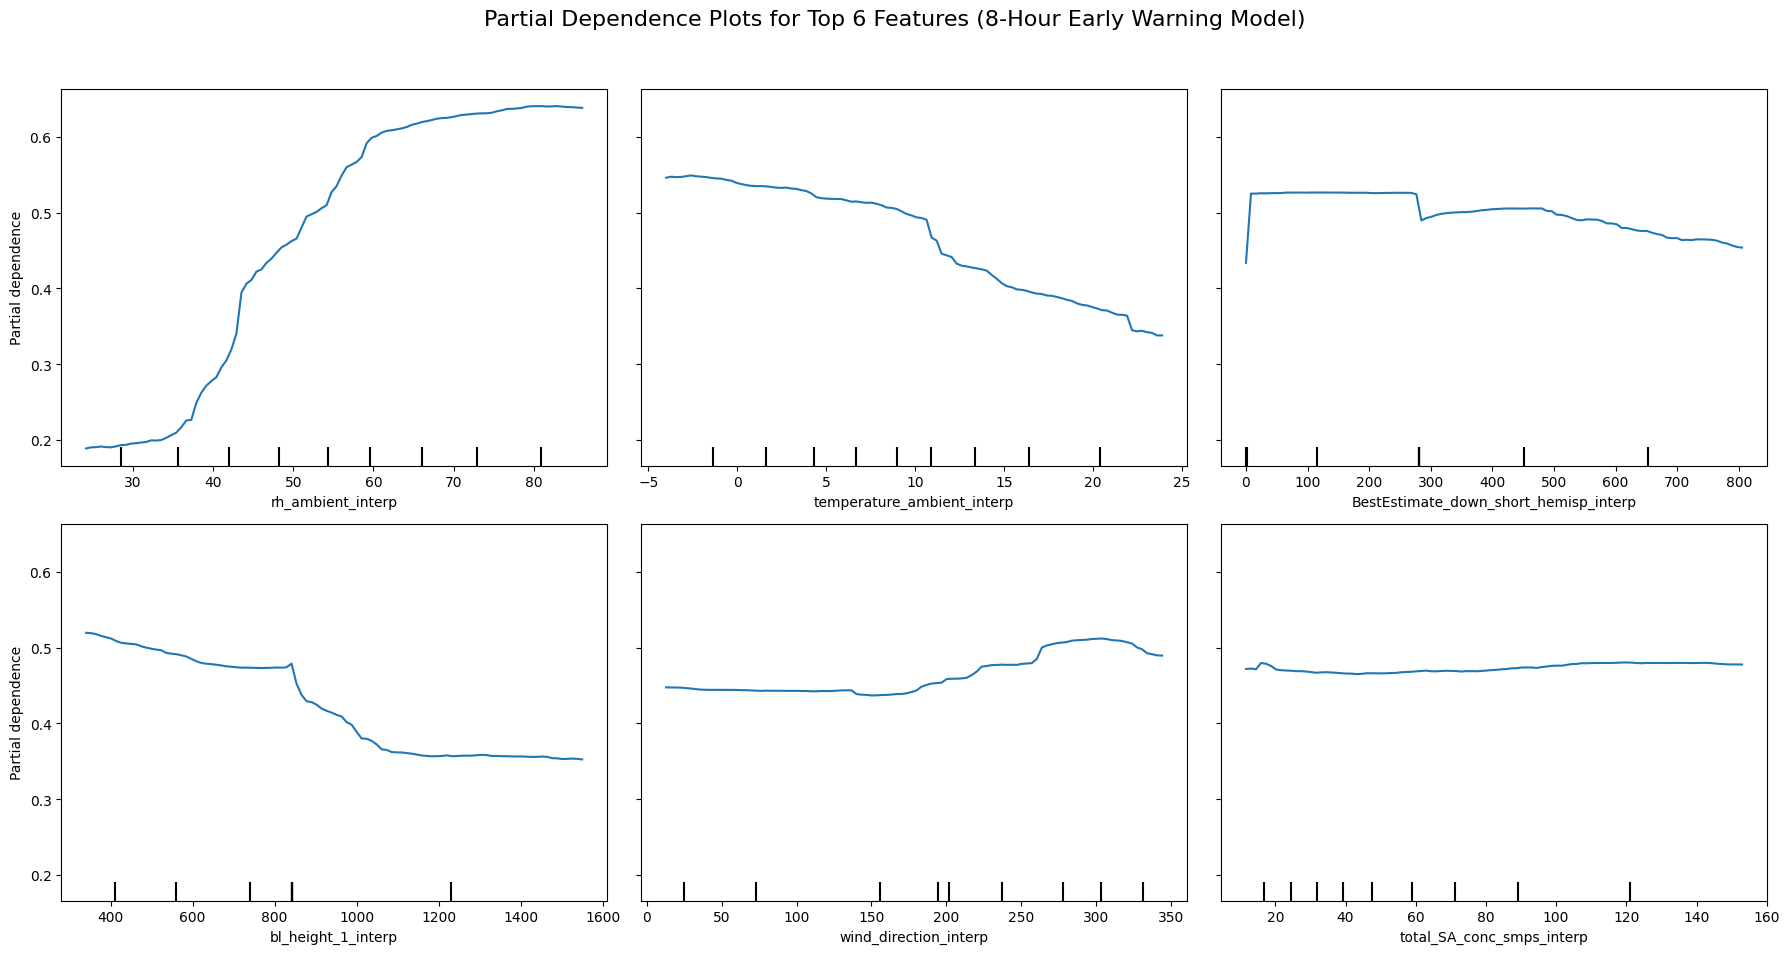

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=120):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=120)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (8-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

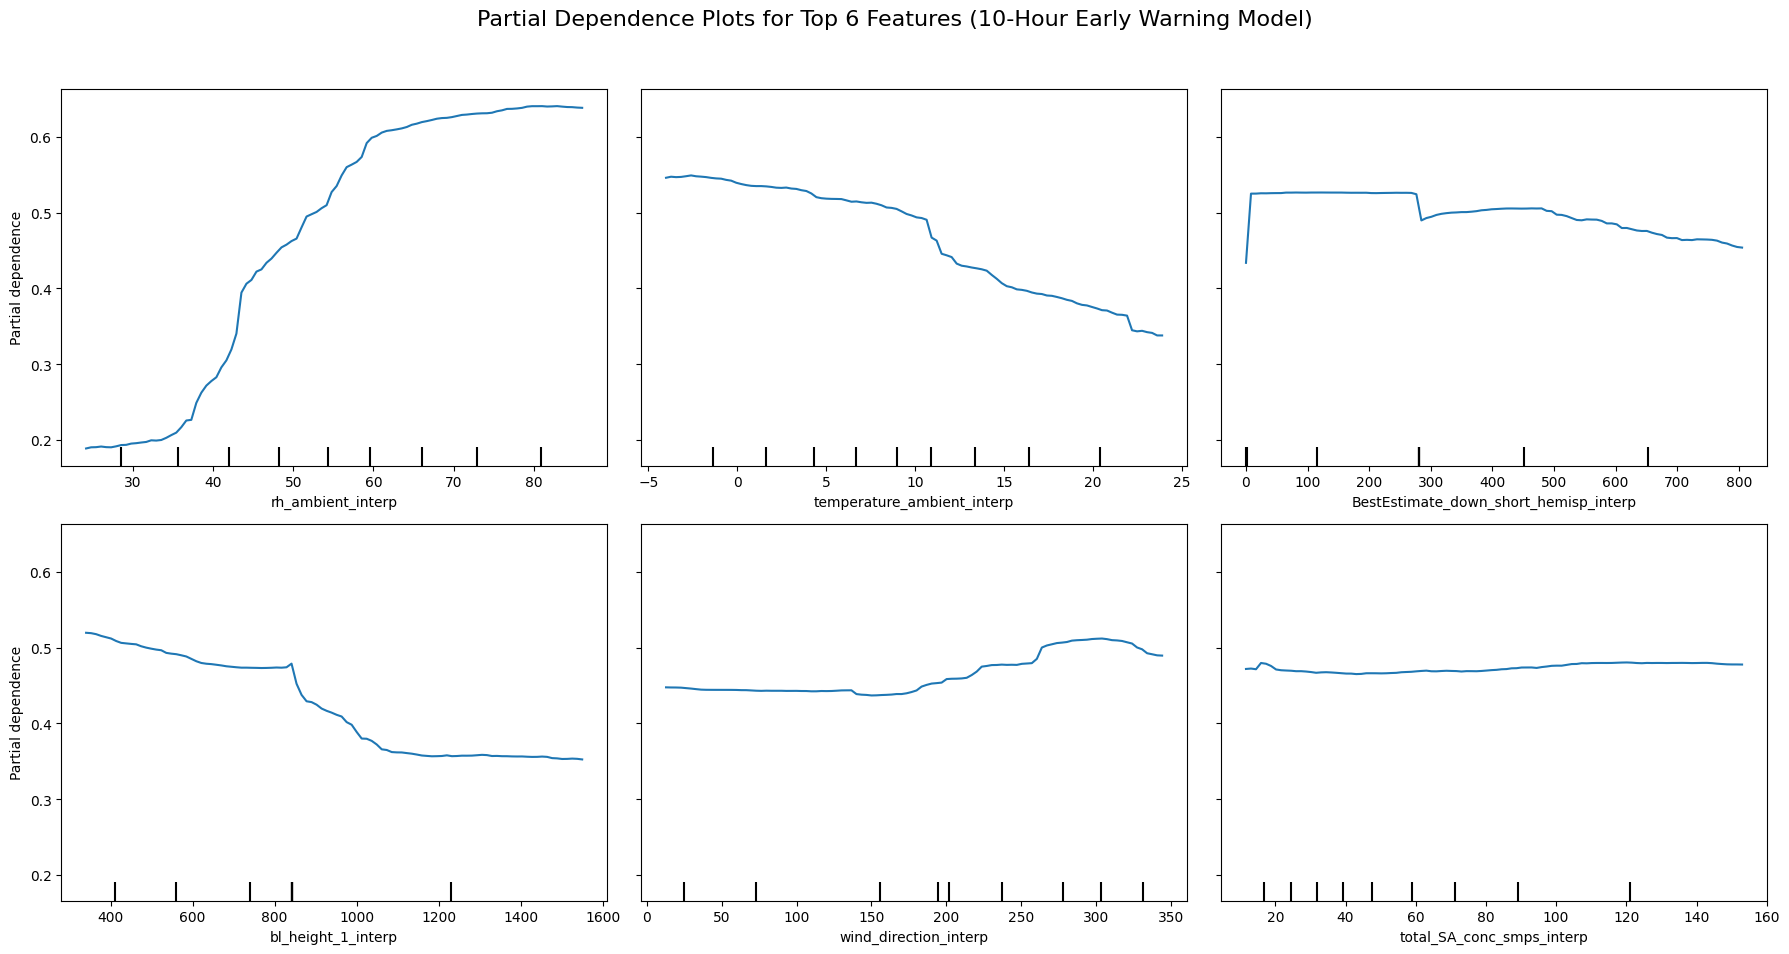

In [ ]:

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (10-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[ 9393  2563]
 [ 1432 11233]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.82     11956
         1.0       0.81      0.89      0.85     12665

    accuracy                           0.84     24621
   macro avg       0.84      0.84      0.84     24621
weighted avg       0.84      0.84      0.84     24621

ROC AUC Score: 0.9246


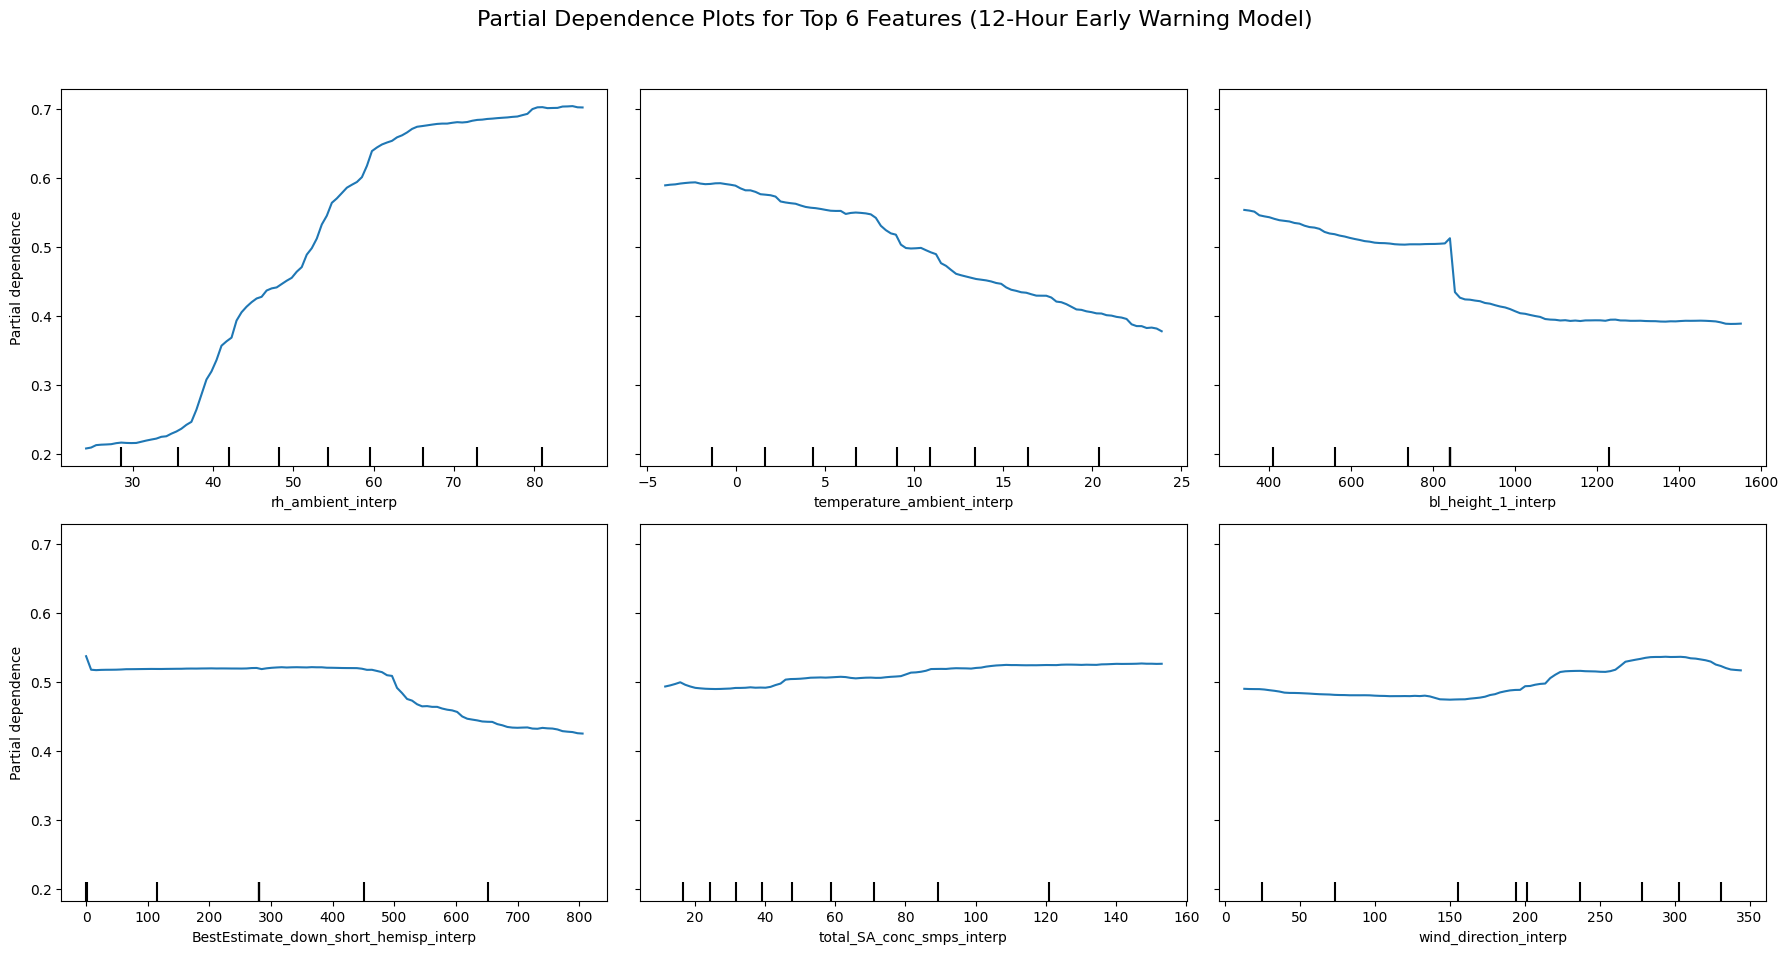

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=144):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=144)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (12-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **XGboost**

In [ ]:
# 📦 Install packages (run only once if not already installed)
!pip install xgboost imbalanced-learn

In [ ]:
# 📚 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 📌 Step 1: Load data
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

# 📌 Step 2: Mark early-warning NPF signal (e.g., 3 hours = 36 steps)
def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=36)

# 📌 Step 3: Select feature columns and target
features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

# 📌 Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 📌 Step 5: Handle imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 📌 Step 6: Train XGBoost classifier
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train_resampled, y_train_resampled)

# 📌 Step 7: Make predictions
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# 📌 Step 8: Evaluate performance
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\n🔥 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:49:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Confusion Matrix:
[[20063  1248]
 [  356  2954]]

📈 Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21311
         1.0       0.70      0.89      0.79      3310

    accuracy                           0.93     24621
   macro avg       0.84      0.92      0.87     24621
weighted avg       0.94      0.93      0.94     24621


🔥 ROC AUC Score: 0.9752


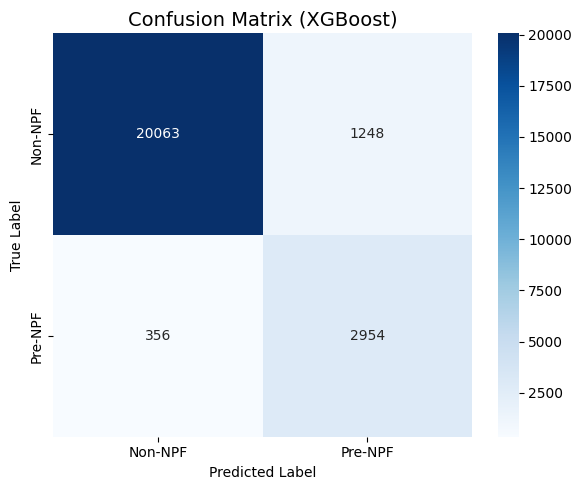

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create labeled heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-NPF', 'Pre-NPF'],
            yticklabels=['Non-NPF', 'Pre-NPF'])

plt.title('Confusion Matrix (XGBoost)', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


<ipython-input-4-2368727575>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


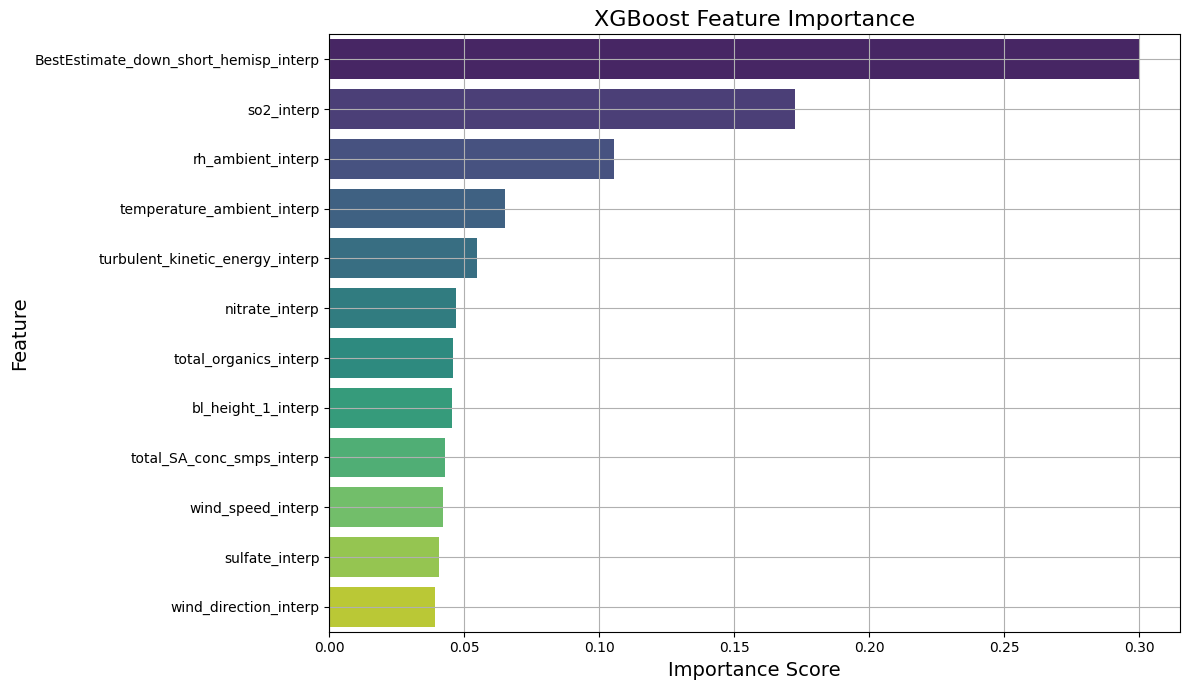

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Step 9: Feature importance plot using Seaborn
feature_importances = xgb.feature_importances_

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
